# Italian Financial Challenge

**Student Name:** Simone Prezioso, Claudio De Acutis, Alexandre Viallard, Alessandro Vertunni

**Challenge:** Financial Health Classification

**Date:** 5/02/2026

---

## Instructions

This template provides a suggested structure for your challenge solution. You can adapt it to your needs, but make sure to cover all required sections:

1. Problem Statement and Objectives
2. Data Loading and Exploration
3. Data Preprocessing
4. Feature Engineering
5. Model Development
6. Model Evaluation
7. Interpretation and Business Insights
8. Conclusions and Future Work

**Remember:**
- Document your thought process with markdown cells
- Comment your code clearly
- Create visualizations to support your insights
- Interpret results in business terms
- Check the evaluation rubric to ensure you meet all criteria

## 1. Problem Statement and Objectives

**Challenge:**
We chose the "Financial Health Classification" in order to push ourselves outside our comfort zone just enough to learn as much as much as possible while working on an amazingly interesting project, we didn't want to go for something too easy such as task 1 or something that would've required time that we didnt have such as task 3.

**Objective:**
Our goal is to build a model capable of confidently classifying companies into 4 distinct categories based on their financial "health":
A: Excellent financial health
B: Good financial health
C: Moderate risk
D: High risk / Distressed

**Success Criteria:**
We can divide our criteria into 3 categories:
1) Metrics: Weighted F1-score ≥ 0.65 on the held-out test set
2) Errors: No extreme ordinal errors, specifically no A → D or D → A misclassifications in the confusion matrix
3) Interpretability: Clear and class-specific feature importance analysis (e.g. per-class SHAP values or one-vs-rest explanations), with financially coherent drivers for classes A, B, C, and D.

**Approach:** Divide tasks between 4 team members, cross-supervise eachothers parts, review finished section together to assess validity of outcomes

In [1]:
# Import libraries
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
import xgboost as xgb
import lightgbm as lgb
import imblearn as imb
import shap
import plotly as px

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8-darkgrid')

# Set random seed for reproducibility
RANDOM_STATE = 67
np.random.seed(RANDOM_STATE)


print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Data Loading and Exploration

We load the training data and retrieve essential informations about the dataset, the shape, the columns and the first ten rows.

In [ ]:
# Load training data
train_df = pd.read_csv('/content/train_data.csv')

print(f"Dataset shape: {train_df.shape}")
print(f"\nColumns: {train_df.columns.tolist()}")
print(f"\nFirst few rows:")

display(train_df.head())

Dataset shape: (11828, 30)

Columns: ['company_id', 'fiscal_year', 'province', 'region', 'ateco_sector', 'legal_form', 'years_in_business', 'total_fixed_assets', 'current_assets', 'total_assets', 'shareholders_equity', 'total_debt', 'short_term_debt', 'long_term_debt', 'production_value', 'production_costs', 'operating_income', 'financial_income', 'financial_expenses', 'net_profit_loss', 'roe', 'roi', 'leverage', 'current_ratio', 'quick_ratio', 'debt_to_assets', 'profit_margin', 'bankruptcy_next_year', 'financial_health_class', 'revenue_change']

First few rows:


company_id  fiscal_year province    region  ateco_sector legal_form  \
0  COMP_00000         2018      NaN  Campania            47        SRL   
1  COMP_00000         2019      NaN  Campania            47        SRL   
2  COMP_00000         2020      NaN  Campania            47        SRL   
3  COMP_00000         2021      NaN  Campania            47        SRL   
4  COMP_00001         2018       CA  Sardegna            62        SRL   

   years_in_business  total_fixed_assets  current_assets  total_assets  \
0                 32        2.422343e+08    9.504819e+08  1.192716e+09   
1                 33        3.983639e+07    1.411226e+08  1.809589e+08   
2                 34        6.662250e+08    1.367208e+09  2.033433e+09   
3                 35        4.637187e+07    2.524228e+08  2.987947e+08   
4                  8        8.348035e+07    1.325697e+08  2.160500e+08   

   shareholders_equity    total_debt  short_term_debt  long_term_debt  \
0         3.728702e+08  8.198459e+08     5.601842e+08    2.596617e+08   
1         5.700701e+07  1.239519e+08     7.135345e+07    5.259848e+07   
2         3.029046e+08  1.730529e+09     9.904004e+08    7.401282e+08   
3         3.901098e+07  2.597837e+08     1.527674e+08    1.070163e+08   
4         6.566937e+07  1.503807e+08     7.582482e+07    7.455584e+07   

   production_value  production_costs  operating_income  financial_income  \
0      1.846636e+09      1.611363e+09      2.352729e+08        4886785.12   
1      4.289159e+08      3.896038e+08      3.931218e+07          58246.06   
2      6.956197e+09      6.988489e+09     -3.229208e+07        5327332.51   
3      5.031839e+08      5.047235e+08     -1.539645e+06         116335.80   
4      4.113380e+08      3.912414e+08      2.009667e+07         640538.94   

   financial_expenses  net_profit_loss     roe     roi  leverage  \
0         20068071.29     2.152049e+08  0.5772  0.1973    2.1987   
1          2537224.20     3.677495e+07  0.6451  0.2172    2.1743   
2         55844558.38    -8.813664e+07 -0.2910 -0.0159    5.7131   
3          7828741.61    -9.368387e+06 -0.2401 -0.0052    6.6592   
4          5860639.22     1.423603e+07  0.2168  0.0930    2.2900   

   current_ratio  quick_ratio  debt_to_assets  profit_margin  \
0         1.6967       1.0180          0.6874         0.1165   
1         1.9778       1.1867          0.6850         0.0857   
2         1.3805       0.8283          0.8510        -0.0127   
3         1.6523       0.9914          0.8694        -0.0186   
4         1.7484       1.0490          0.6960         0.0346   

   bankruptcy_next_year financial_health_class  revenue_change  
0                     0                      B             NaN  
1                     0                      B          -76.77  
2                     0                      D         1521.81  
3                     0                      D          -92.77  
4                     0                      B             NaN

We first distinguish between categorical and numerical variables to guide preprocessing decisions.
Although `ateco_sector` is numerically encoded, it represents industry classification codes rather than measurable quantities. Consequently, it is converted to a categorical variable to prevent misleading numerical interpretations.


In [3]:
# Basic information
train_df.info()

cateogrical_cols = train_df.select_dtypes(include=['object', 'category']).columns
train_df['ateco_sector'] = train_df['ateco_sector'].astype('object') # Convert 'ateco_sector' to categorical since numbers represent categories and not continuous values
print(f"\nCategorical columns: {cateogrical_cols.tolist()}")
# Convert 'bankruptcy_next_year' to categorical with meaningful labels (0='No', 1='Yes')
train_df['bankruptcy_next_year'] = train_df['bankruptcy_next_year'].map({0: False, 1: True})
train_df['bankruptcy_next_year'] = train_df['bankruptcy_next_year'].astype('object')

numerical_cols = train_df.select_dtypes(include=['number']).columns
print(f"\nNumerical columns: {numerical_cols.tolist()}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11828 entries, 0 to 11827
Data columns (total 30 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   company_id              11828 non-null  object 
 1   fiscal_year             11828 non-null  int64  
 2   province                10909 non-null  object 
 3   region                  11828 non-null  object 
 4   ateco_sector            11828 non-null  int64  
 5   legal_form              11828 non-null  object 
 6   years_in_business       11828 non-null  int64  
 7   total_fixed_assets      11828 non-null  float64
 8   current_assets          11828 non-null  float64
 9   total_assets            11828 non-null  float64
 10  shareholders_equity     11828 non-null  float64
 11  total_debt              11828 non-null  float64
 12  short_term_debt         11828 non-null  float64
 13  long_term_debt          11828 non-null  float64
 14  production_value        11828 non-null

We first display summary statistics for the numerical variables.
We then visualize their distributions across different financial health classes and, to improve interpretability, extreme values are clipped at the 5th and 95th percentiles for visualization purposes only.


fiscal_year  years_in_business  total_fixed_assets  current_assets  \
count  11828.000000       11828.000000        1.182800e+04    1.182800e+04   
mean    2019.495350          35.179405        1.029206e+09    1.438435e+09   
std        1.116482          19.908095        6.120958e+09    6.873106e+09   
min     2018.000000           0.000000        1.267167e+06    1.278800e+06   
25%     2018.000000          18.000000        7.319803e+07    1.244471e+08   
50%     2019.000000          35.000000        1.905995e+08    3.125597e+08   
75%     2020.000000          52.000000        5.398741e+08    8.387197e+08   
max     2021.000000          71.000000        2.548712e+11    2.512549e+11   

       total_assets  shareholders_equity    total_debt  short_term_debt  \
count  1.182800e+04         1.182800e+04  1.182800e+04     1.182800e+04   
mean   2.467641e+09         9.163141e+08  1.551327e+09     8.534656e+08   
std    1.248305e+10         5.023564e+09  7.724478e+09     4.360360e+09   
min    2.545968e+06        -3.330561e+09  1.839791e+06     8.985461e+05   
25%    2.087793e+08         7.070428e+07  1.294646e+08     6.925617e+07   
50%    5.212379e+08         1.815958e+08  3.264152e+08     1.744802e+08   
75%    1.394478e+09         5.022747e+08  8.795087e+08     4.777298e+08   
max    5.061262e+11         1.956145e+11  3.105116e+11     1.699685e+11   

       long_term_debt  production_value  production_costs  operating_income  \
count    1.182800e+04      1.182800e+04      1.182800e+04      1.182800e+04   
mean     6.978617e+08      3.969063e+09      3.680129e+09      2.889337e+08   
std      3.493369e+09      1.896096e+10      1.757911e+10      1.574126e+09   
min      9.412449e+05      2.329670e+06      1.580518e+06     -2.688184e+09   
25%      5.666362e+07      2.984883e+08      2.731290e+08      1.698626e+07   
50%      1.462585e+08      8.040019e+08      7.459428e+08      5.128590e+07   
75%      3.960070e+08      2.241163e+09      2.075266e+09      1.538062e+08   
max      1.405431e+11      6.044366e+11      5.736470e+11      5.621927e+10   

       financial_income  financial_expenses  net_profit_loss           roe  \
count      1.182800e+04        1.182800e+04     1.182800e+04  11783.000000   
mean       6.418314e+06        5.464980e+07     2.342839e+08      0.254267   
std        3.930832e+07        2.850800e+08     1.348222e+09      0.577374   
min        6.241000e+01        5.926949e+04    -4.062689e+09    -39.177100   
25%        3.569547e+05        4.355200e+06     1.049173e+07      0.110350   
50%        1.068330e+06        1.110262e+07     3.798727e+07      0.221600   
75%        3.178533e+06        3.005698e+07     1.226862e+08      0.390750   
max        1.640114e+09        9.311030e+09     5.011818e+10      1.771600   

                roi      leverage  current_ratio   quick_ratio  \
count  11828.000000  11783.000000   11828.000000  11828.000000   
mean       0.123253      2.135329       1.869953      1.121972   
std        0.091036      2.159040       0.614015      0.368409   
min       -0.475300      0.818200       0.551000      0.330600   
25%        0.061900      1.165650       1.430800      0.858500   
50%        0.105000      1.680300       1.811750      1.087050   
75%        0.170900      2.484850       2.238925      1.343325   
max        0.490600    101.153800       4.539300      2.723600   

       debt_to_assets  profit_margin  revenue_change  
count    11828.000000   11828.000000     8829.000000  
mean         0.633231       0.058008      453.434570  
std          0.114868       0.039245     4601.920625  
min          0.450000      -0.149700      -99.940000  
25%          0.538500       0.030500      -68.590000  
50%          0.627500       0.060300        3.040000  
75%          0.713800       0.090000      238.850000  
max          1.192300       0.120000   302126.480000

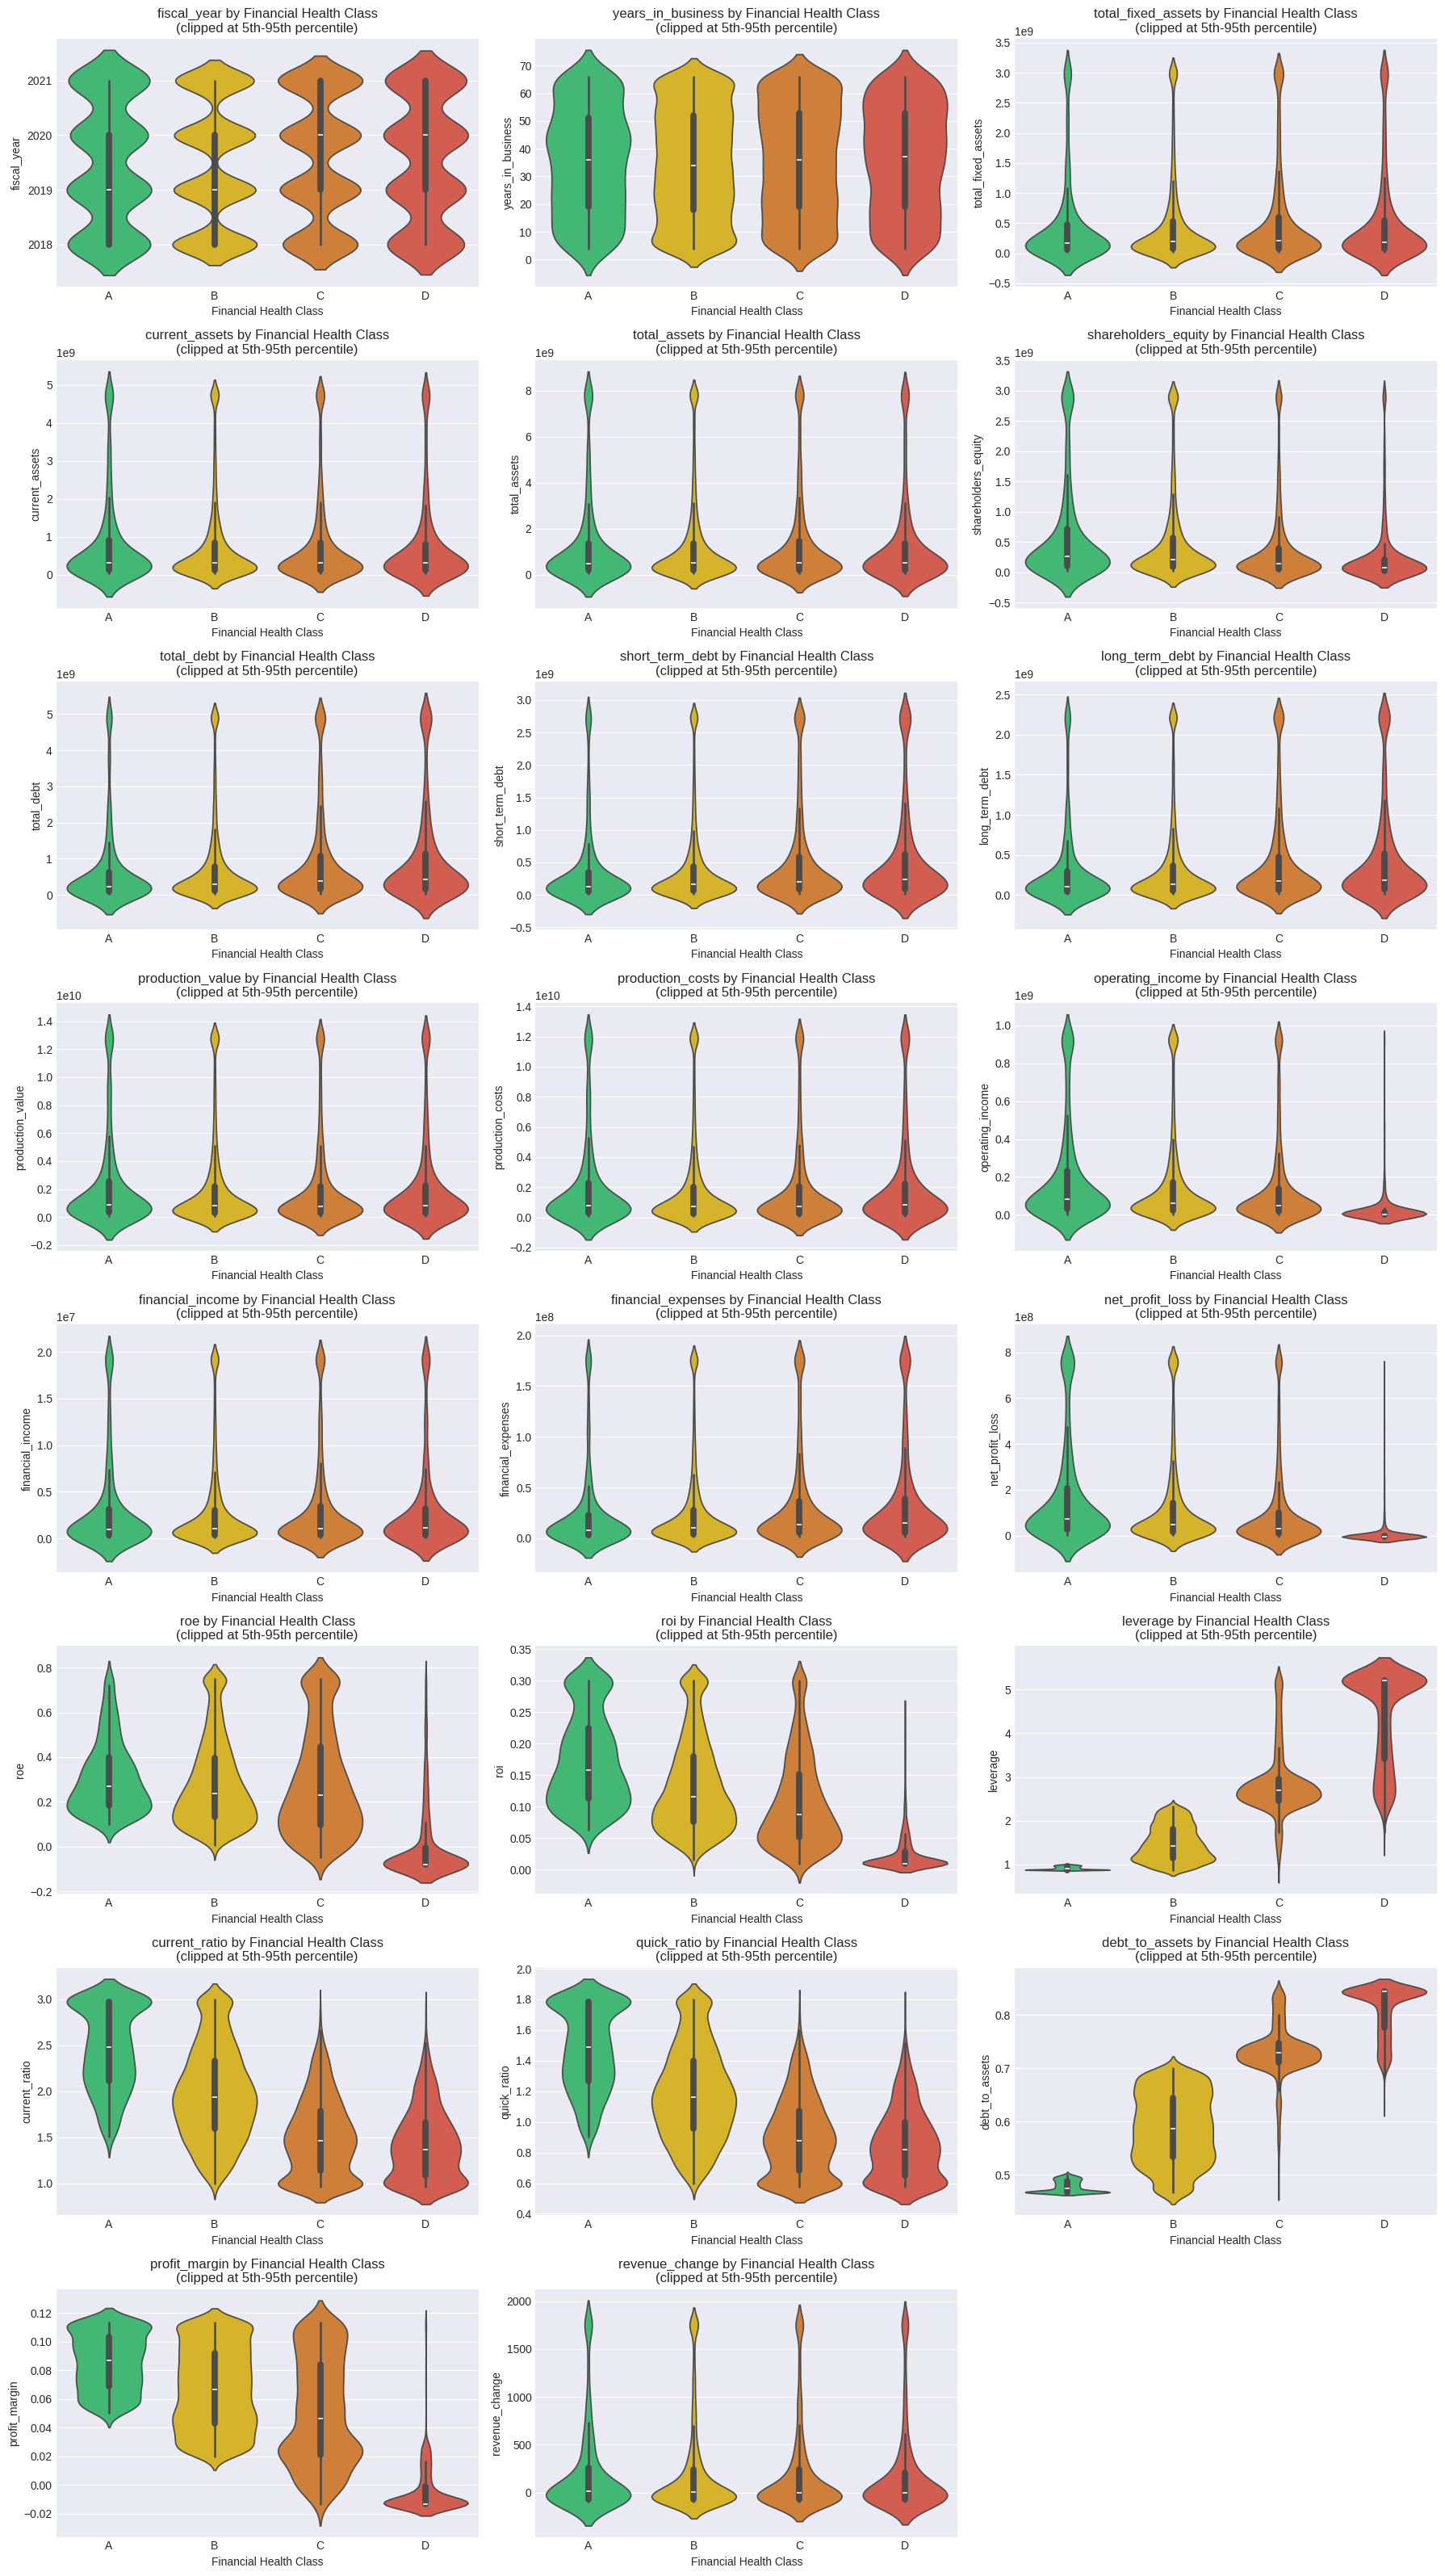

In [4]:
# Summary statistics
display(train_df.describe())

# Clipping outliers at 95th percentile for better visualization
import math
train_df_clipped = train_df.copy()
for col in numerical_cols:
    percentile_95 = train_df_clipped[col].quantile(0.95)
    percentile_5 = train_df_clipped[col].quantile(0.05)
    train_df_clipped[col] = train_df_clipped[col].clip(lower=percentile_5, upper=percentile_95)

# Violin plots with clipped data to visualize distribution by financial health class
n_cols = 3
n_rows = math.ceil(len(numerical_cols) / n_cols)
plt.figure(figsize=(18, 4*n_rows))

for i, col in enumerate(numerical_cols):
    plt.subplot(n_rows, n_cols, i+1)
    sns.violinplot(data=train_df_clipped, x='financial_health_class', y=col,
                   order=['A', 'B', 'C', 'D'],
                   palette=['#2ecc71', '#f1c40f', '#e67e22', '#e74c3c'])
    plt.title(f'{col} by Financial Health Class\n(clipped at 5th-95th percentile)')
    plt.xlabel('Financial Health Class')

plt.tight_layout()
plt.show()

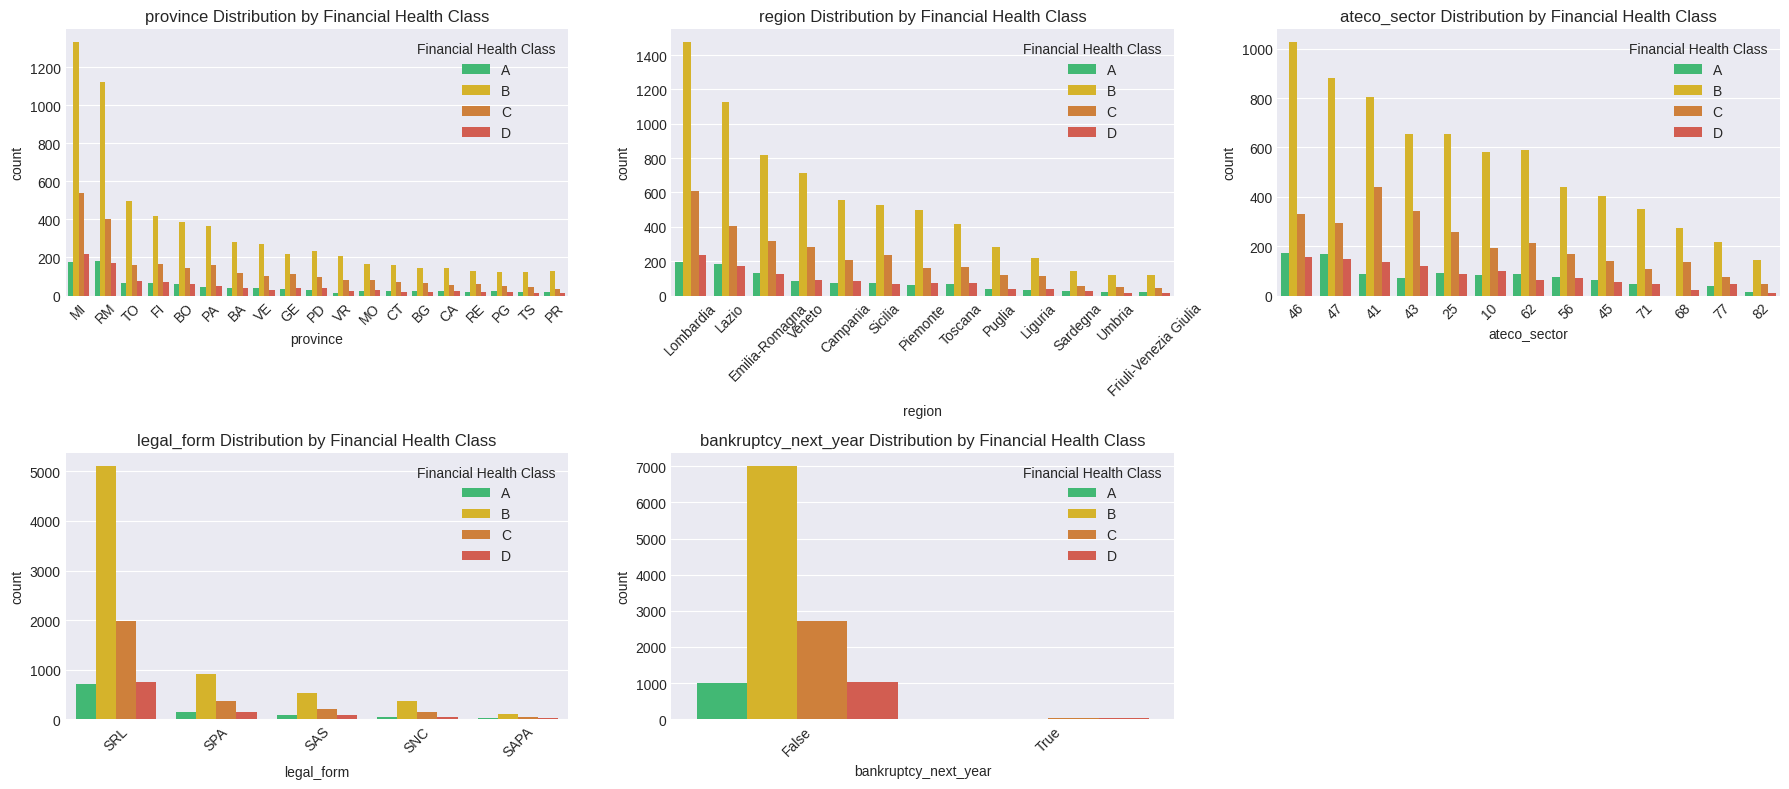

In [ ]:
#Barplots for all catgorical features not only ateco but every categorical feature

categorical_cols = [col for col in train_df.columns if train_df[col].dtype == 'object' and col != 'financial_health_class' and col != "company_id"] + [col for col in train_df.columns if train_df[col].dtype.name == 'category' and col != 'financial_health_class' and col != "company_id"]
n_cols = 3
n_rows = math.ceil(len(categorical_cols) / n_cols)
plt.figure(figsize=(18, 4*n_rows))
for i, col in enumerate(categorical_cols):
    plt.subplot(n_rows, n_cols, i+1)
    sns.countplot(data=train_df, x=col, hue='financial_health_class', hue_order=['A', 'B', 'C', 'D'],
                  order=train_df[col].value_counts().index,
                  palette=['#2ecc71', '#f1c40f', '#e67e22', '#e74c3c'])
    plt.title(f'{col} Distribution by Financial Health Class')
    plt.xlabel(col)
    plt.xticks(rotation=45)
    plt.legend(title='Financial Health Class')
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import f_classif

train_df_temp = train_df.copy()
train_df_temp = train_df_temp.dropna()

train_df_temp['health_numeric'] = train_df_temp['financial_health_class'].map(
    {'A': 4, 'B': 3, 'C': 2, 'D': 1}
)

numeric_cols = train_df_temp.select_dtypes(include='number').columns.drop('health_numeric')

X = train_df_temp[numeric_cols]
y = train_df_temp['health_numeric']

mi_scores = mutual_info_classif(X, y, discrete_features=False, random_state=42)
mi_series = pd.Series(mi_scores, index=numeric_cols).sort_values(ascending=False)

# Print significant features based on pvalue < 0.05, alongside their mutual information scores
f_scores, p_values = f_classif(X, y)

mi_aligned = pd.Series(mi_scores, index=numeric_cols)
anova_results = pd.DataFrame({'Feature': numeric_cols.values, 'F-Score': f_scores, 'P-Value': p_values, 'Mutual_info': mi_aligned.values}).reset_index(drop=True)
significant_numeric_features = anova_results[anova_results['P-Value'] < 0.05].sort_values(by='F-Score', ascending=False)
unsignificant_numerical_features = anova_results[anova_results['P-Value'] >= 0.05].sort_values(by='F-Score', ascending=False)

print("\nSignificant features based on ANOVA F-test (p-value < 0.05):")
print(significant_numeric_features)
print("\nNon-significant features based on ANOVA F-test (p-value >= 0.05):")
print(unsignificant_numerical_features)

unsignificant_numerical_features = unsignificant_numerical_features['Feature'].tolist()


Significant features based on ANOVA F-test (p-value < 0.05):
                Feature      F-Score        P-Value  Mutual_info
20       debt_to_assets  6965.951624   0.000000e+00     0.790666
17             leverage  1598.213305   0.000000e+00     0.787500
21        profit_margin  1576.793714   0.000000e+00     0.325399
19          quick_ratio  1078.534475   0.000000e+00     0.198187
18        current_ratio  1078.525527   0.000000e+00     0.200574
16                  roi   647.275933   0.000000e+00     0.232948
15                  roe   172.446484  2.217571e-108     0.236944
14      net_profit_loss    13.431476   9.677717e-09     0.205377
11     operating_income     9.673134   2.272852e-06     0.120952
5   shareholders_equity     6.495098   2.192743e-04     0.028126

Non-significant features based on ANOVA F-test (p-value >= 0.05):
               Feature   F-Score   P-Value  Mutual_info
7      short_term_debt  1.844876  0.136673     0.008252
6           total_debt  1.547145  0.200104  

Visualization of Financial Health classes distribution both with barplots and piechart, to also see the class imbalance.

In [ ]:
# Chi-Square test for categorical features vs financial health class
from scipy.stats import chi2_contingency
train_df_temp = train_df.copy()
train_df_temp = train_df_temp.dropna()
categorical_cols = train_df_temp.select_dtypes(include=['object', 'category']).columns.drop('financial_health_class')
chi2_results = {}
for col in categorical_cols:
    contingency_table = pd.crosstab(train_df_temp[col], train_df_temp['financial_health_class'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    chi2_results[col] = {'chi2_statistic': chi2, 'p_value': p}

print("\nChi-Square Test Results for Categorical Features:")
for col, result in sorted(chi2_results.items()):
    print(f"{col}: chi2_statistic={result['chi2_statistic']:.4f}, p_value={result['p_value']:.4e}")

# Check for significant associations (p < 0.05)
significant_categorical_features = [col for col, result in chi2_results.items() if result['p_value'] < 0.05]
unsignificant_categorical_features = [col for col, result in chi2_results.items() if result['p_value'] >= 0.05]
print(f"\nSignificant categorical features associated with financial health class (p < 0.05): {significant_categorical_features}")
print(f"Categorical features not significantly associated with financial health class (p >= 0.05): {unsignificant_categorical_features}")


Chi-Square Test Results for Categorical Features:
ateco_sector: chi2_statistic=160.6155, p_value=1.1327e-17
bankruptcy_next_year: chi2_statistic=173.8214, p_value=1.9039e-37
company_id: chi2_statistic=8469.3410, p_value=2.0331e-02
legal_form: chi2_statistic=5.8236, p_value=9.2471e-01
province: chi2_statistic=60.4220, p_value=2.5507e-01
region: chi2_statistic=42.6627, p_value=1.2097e-01

Significant categorical features associated with financial health class (p < 0.05): ['company_id', 'ateco_sector', 'bankruptcy_next_year']
Categorical features not significantly associated with financial health class (p >= 0.05): ['province', 'region', 'legal_form']



Financial Health Distribution:
financial_health_class
A    1003
B    7017
C    2750
D    1058
Name: count, dtype: int64


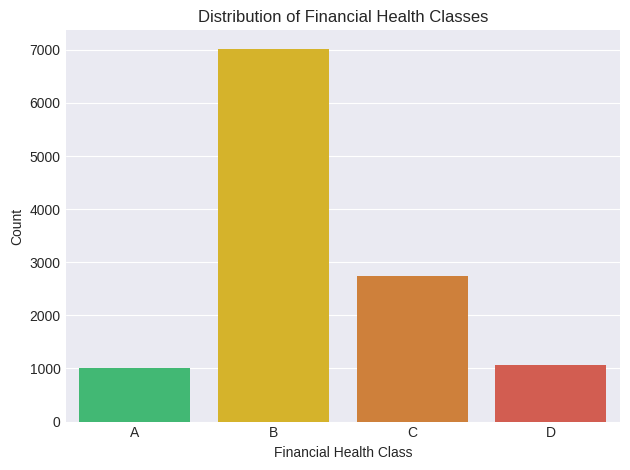


Percentages:
financial_health_class
A    0.0848
B    0.5933
C    0.2325
D    0.0894
Name: proportion, dtype: float64


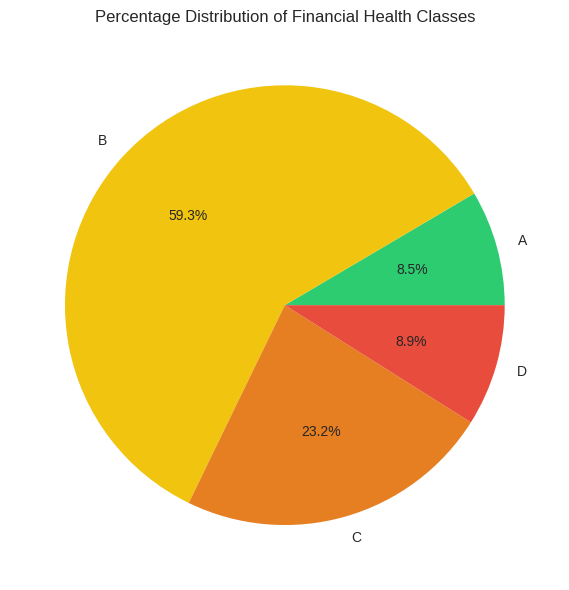

In [8]:
# Financial Health Classification
class_counts = train_df['financial_health_class'].value_counts().sort_index()
print("\nFinancial Health Distribution:")
print(class_counts)

sns.countplot(x='financial_health_class',  data=train_df, order=class_counts.index, palette=['#2ecc71', '#f1c40f', '#e67e22', '#e74c3c'])
plt.title('Distribution of Financial Health Classes')
plt.xlabel('Financial Health Class')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

print("\nPercentages:")
perchentages=train_df['financial_health_class'].value_counts(normalize=True).sort_index().round(4)
print(perchentages)

plt.figure(figsize=(8, 6))
plt.pie(class_counts,
    labels=class_counts.index,
    autopct='%1.1f%%',
    colors=['#2ecc71', '#f1c40f', '#e67e22', '#e74c3c'])
plt.title('Percentage Distribution of Financial Health Classes')
plt.tight_layout()
plt.show()

imbalance_ratio = class_counts.max() / class_counts.min()
if imbalance_ratio > 3 or perchentages.min() < 0.1:
    print(f"\nWarning: The dataset is imbalanced with a ratio of {imbalance_ratio:.2f}.")

From this visualization of datas we can already see some essential informations about the variables and their distribution in the dataset. For example, we can see that some variables (like the ones related to assets) actually follow the same distribution across the datasets, while others like roi, roe, leverage and debt to asset, change within classes


Missing Values:
                Missing Count  Percentage
revenue_change           2999   25.355090
province                  919    7.769699
roe                        45    0.380453
leverage                   45    0.380453


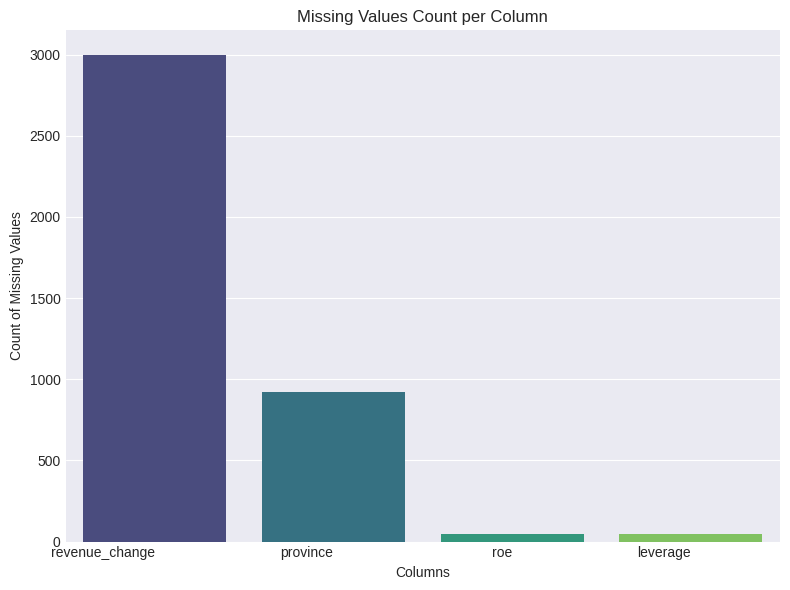

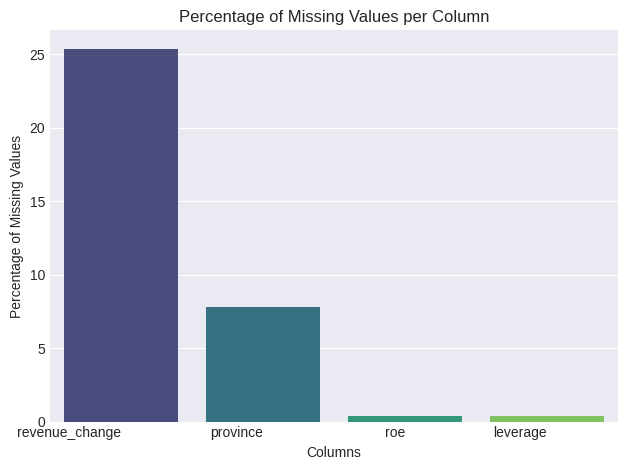

In [ ]:
# Check for missing values
missing_values = train_df.isnull().sum()
missing_pct = (missing_values / len(train_df)) * 100

missing_df = pd.DataFrame({
    'Missing Count': missing_values,
    'Percentage': missing_pct
})
missing_df = missing_df[missing_df['Missing Count'] > 0].sort_values('Missing Count', ascending=False)
print("Missing Values:")
print(missing_df)
missing_counts = train_df.isnull().sum()
missing_counts = missing_counts[missing_counts > 0].sort_values(ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(x=missing_counts.index, y=missing_counts.values, palette='viridis')
plt.xticks( ha='right')
plt.title('Missing Values Count per Column')
plt.ylabel('Count of Missing Values')
plt.xlabel('Columns')
plt.tight_layout()
plt.show()

sns.barplot(x=missing_df.index, y=missing_df['Percentage'], palette='viridis')
plt.xticks(ha='right')
plt.title('Percentage of Missing Values per Column')
plt.ylabel('Percentage of Missing Values')
plt.xlabel('Columns')
plt.tight_layout()
plt.show()

### Exploratory Data Analysis (EDA)

Create visualizations to understand the data better.

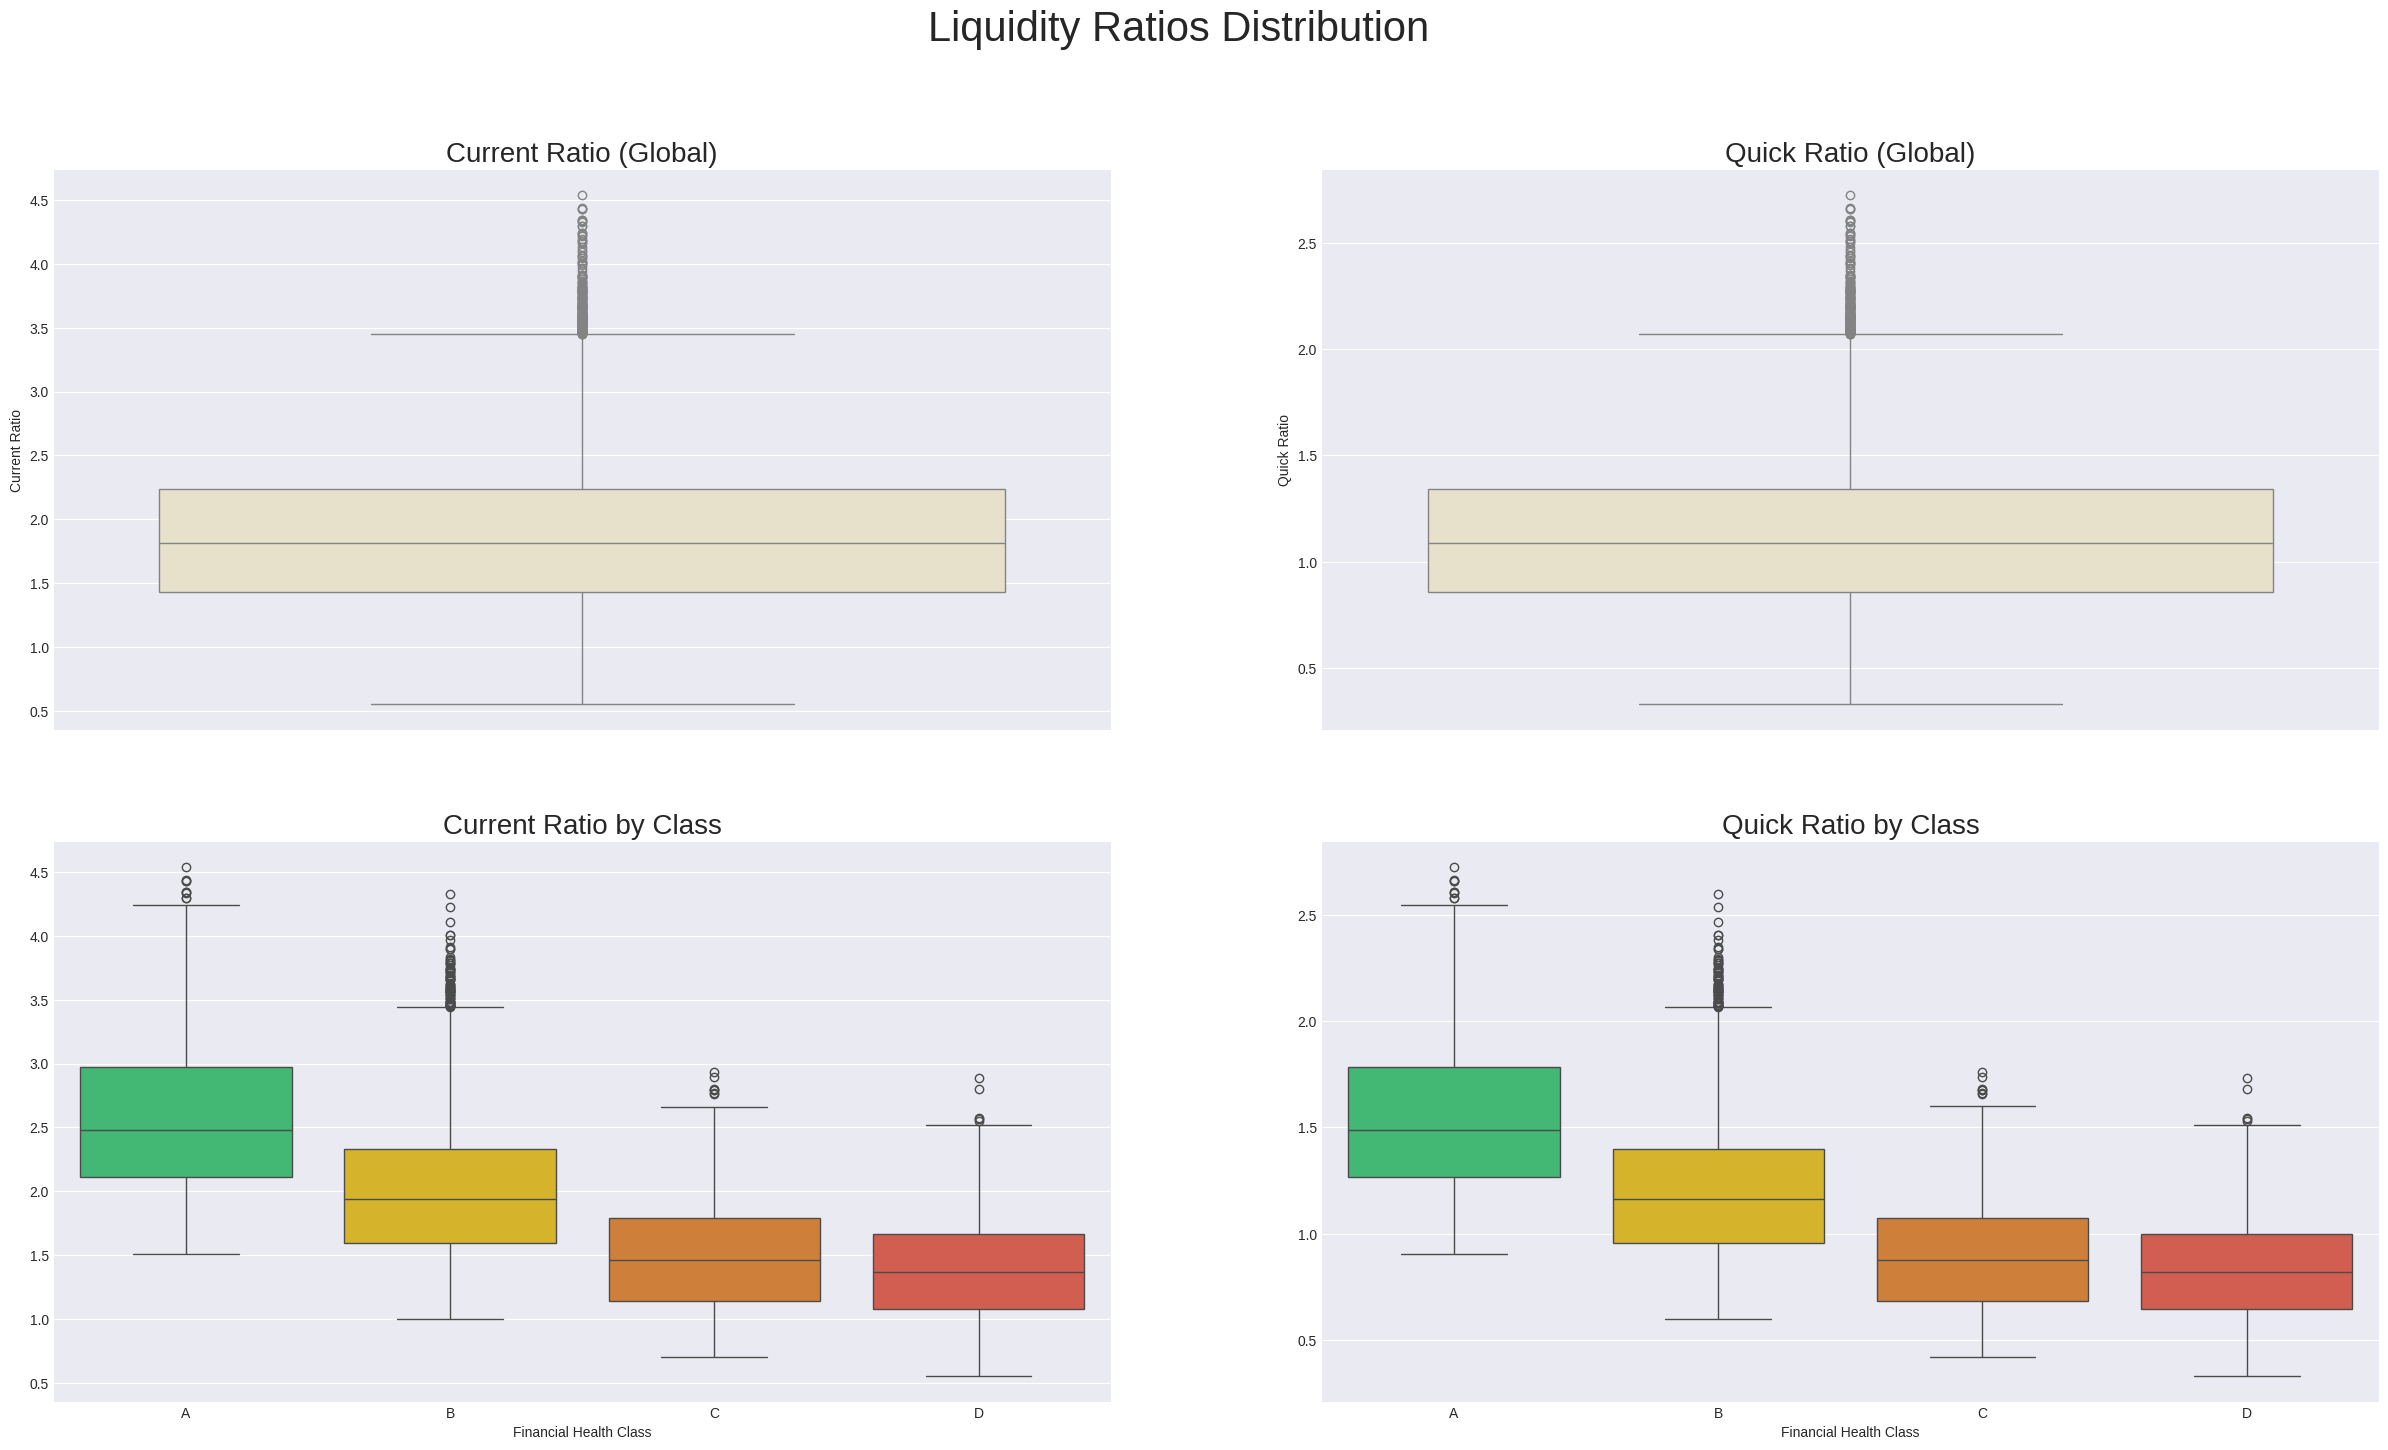

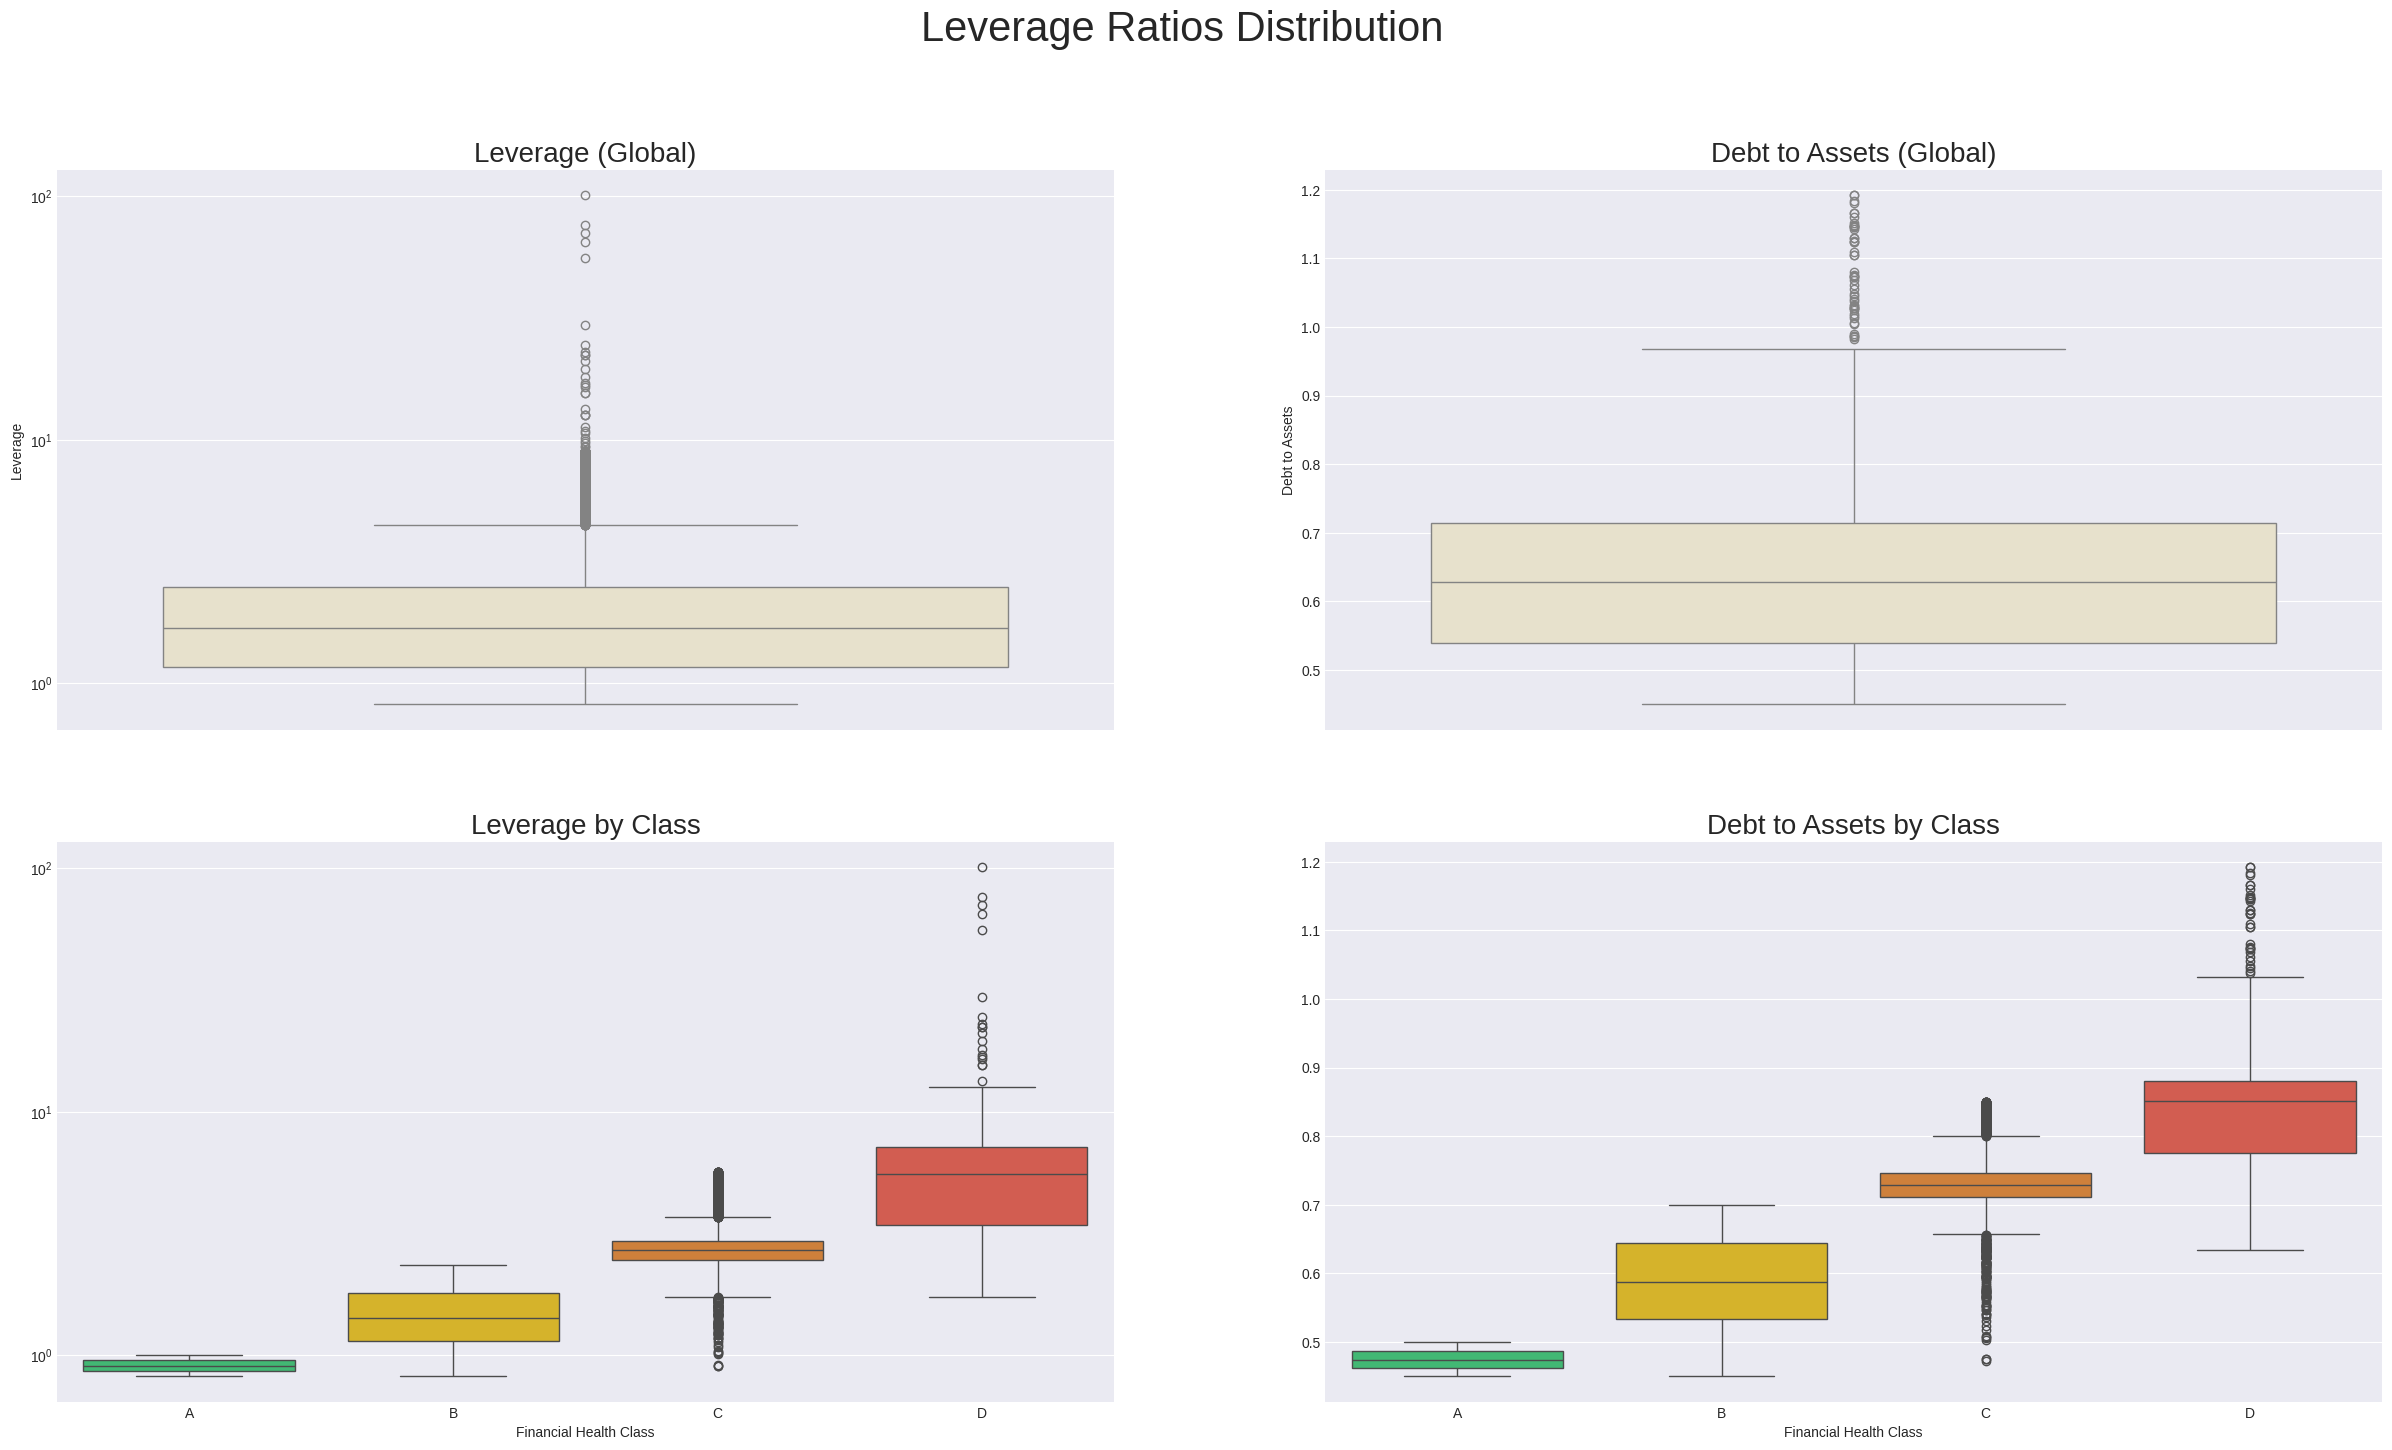

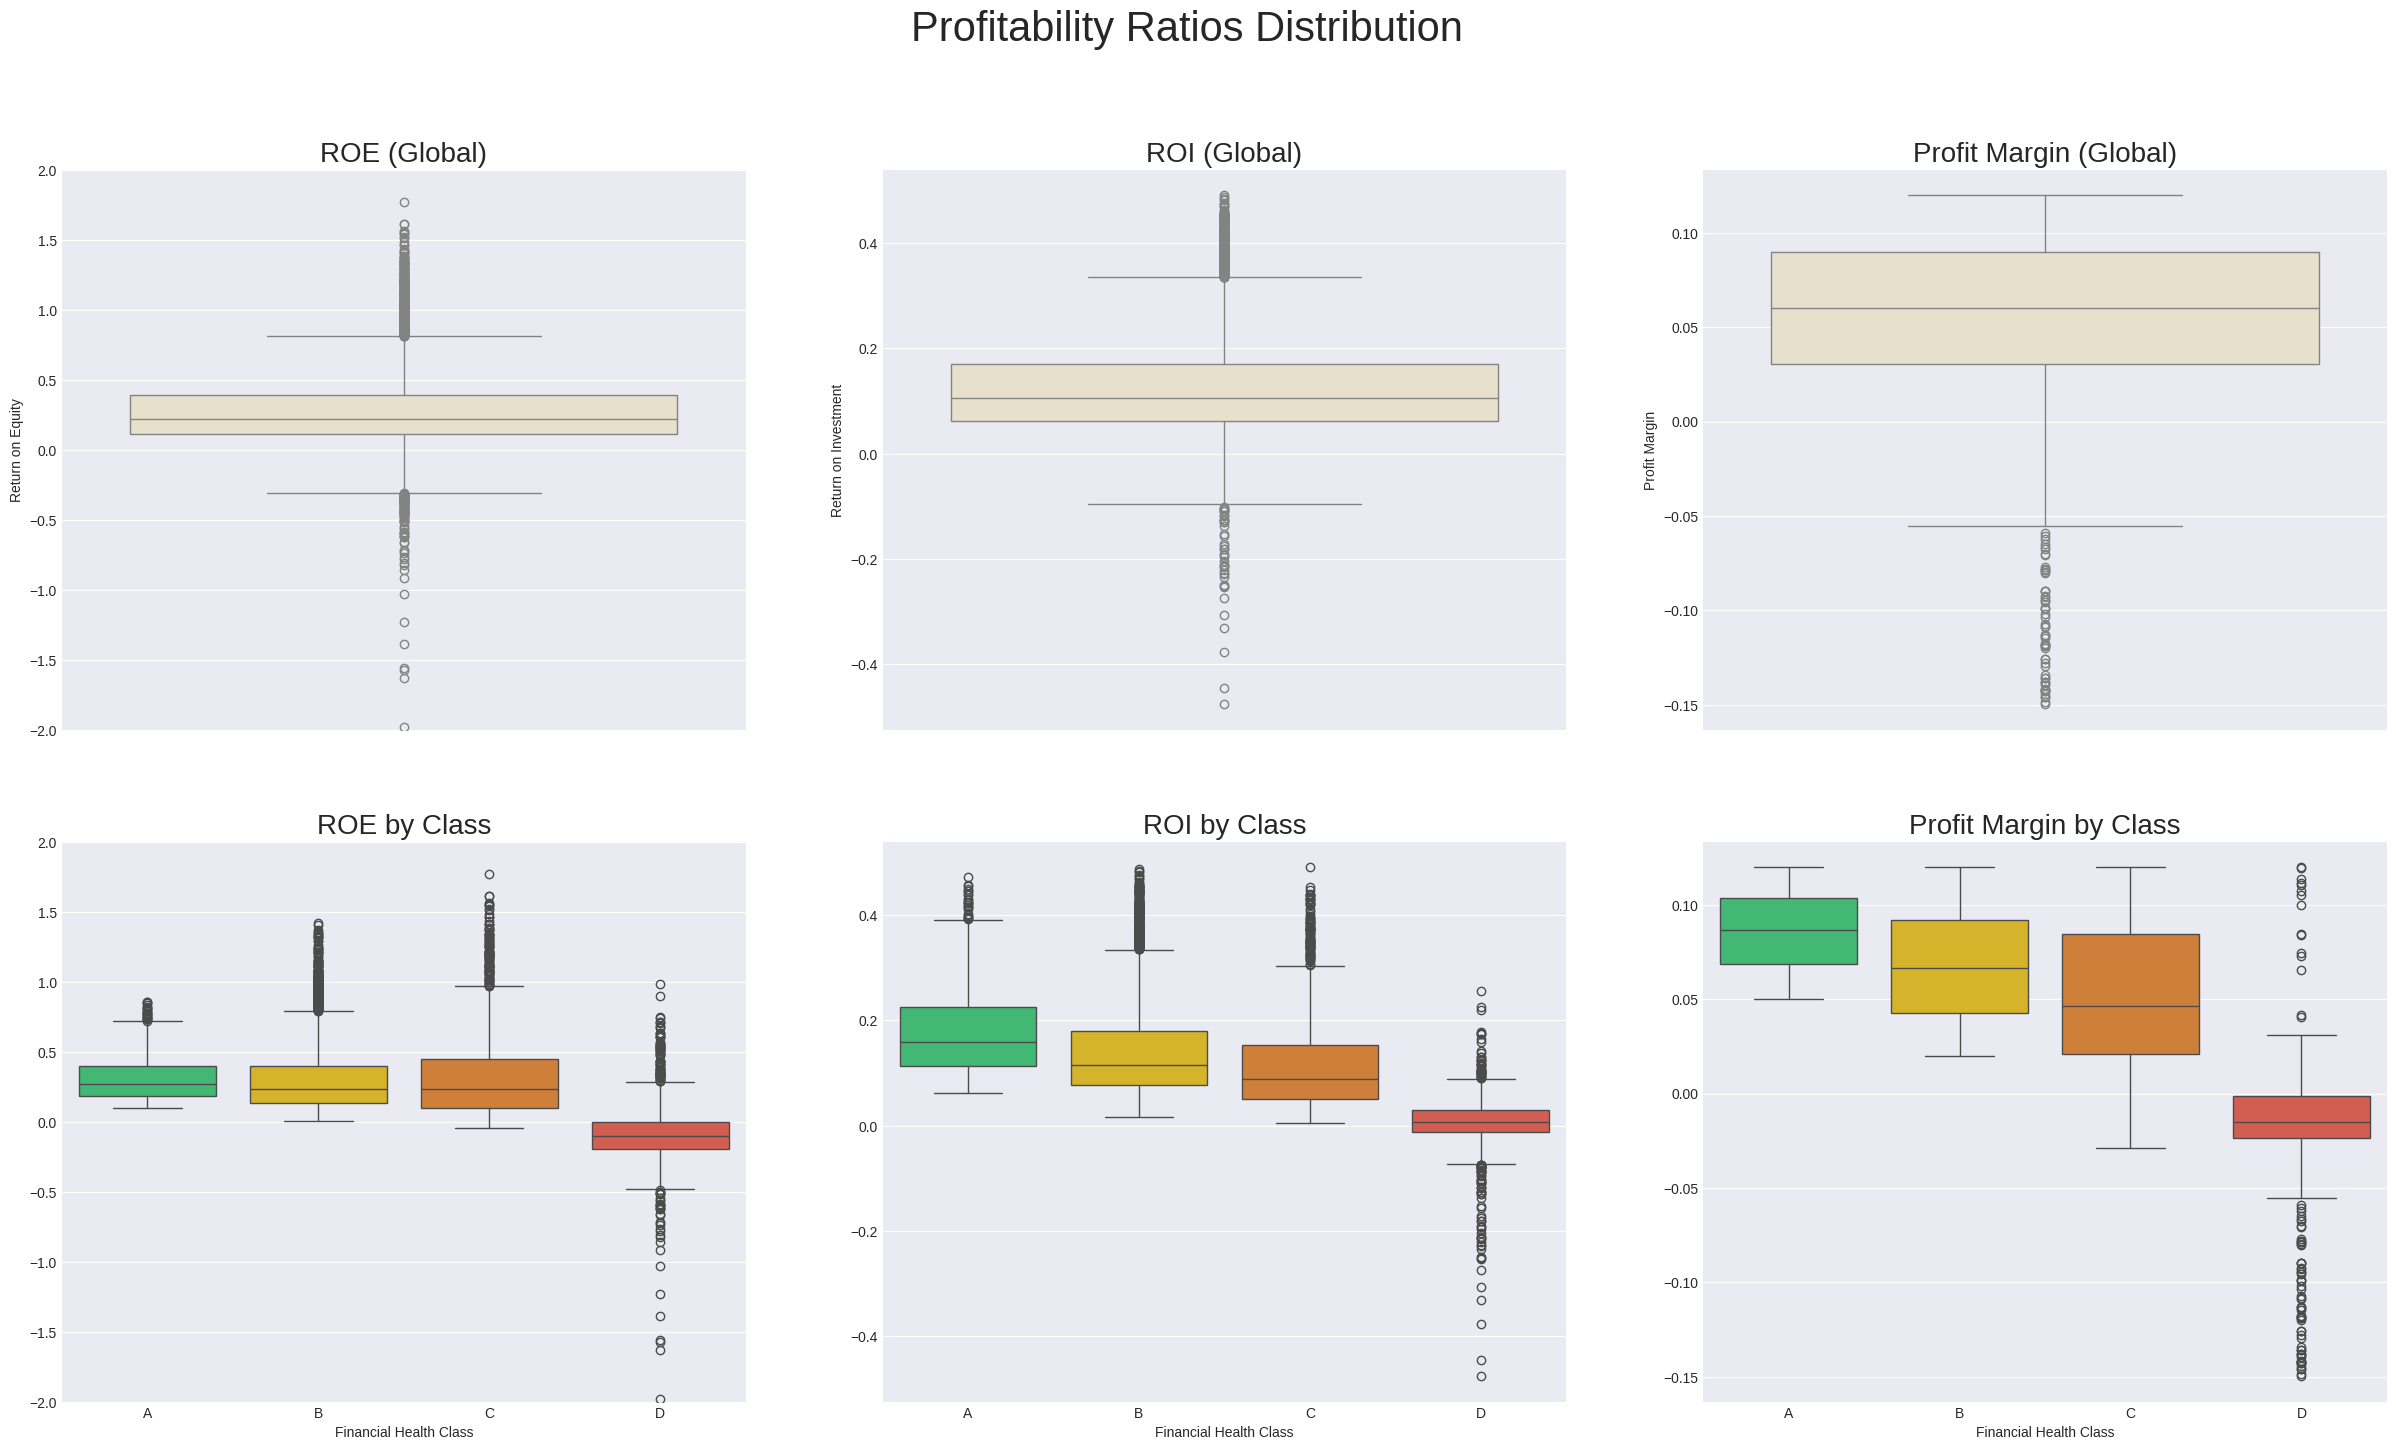

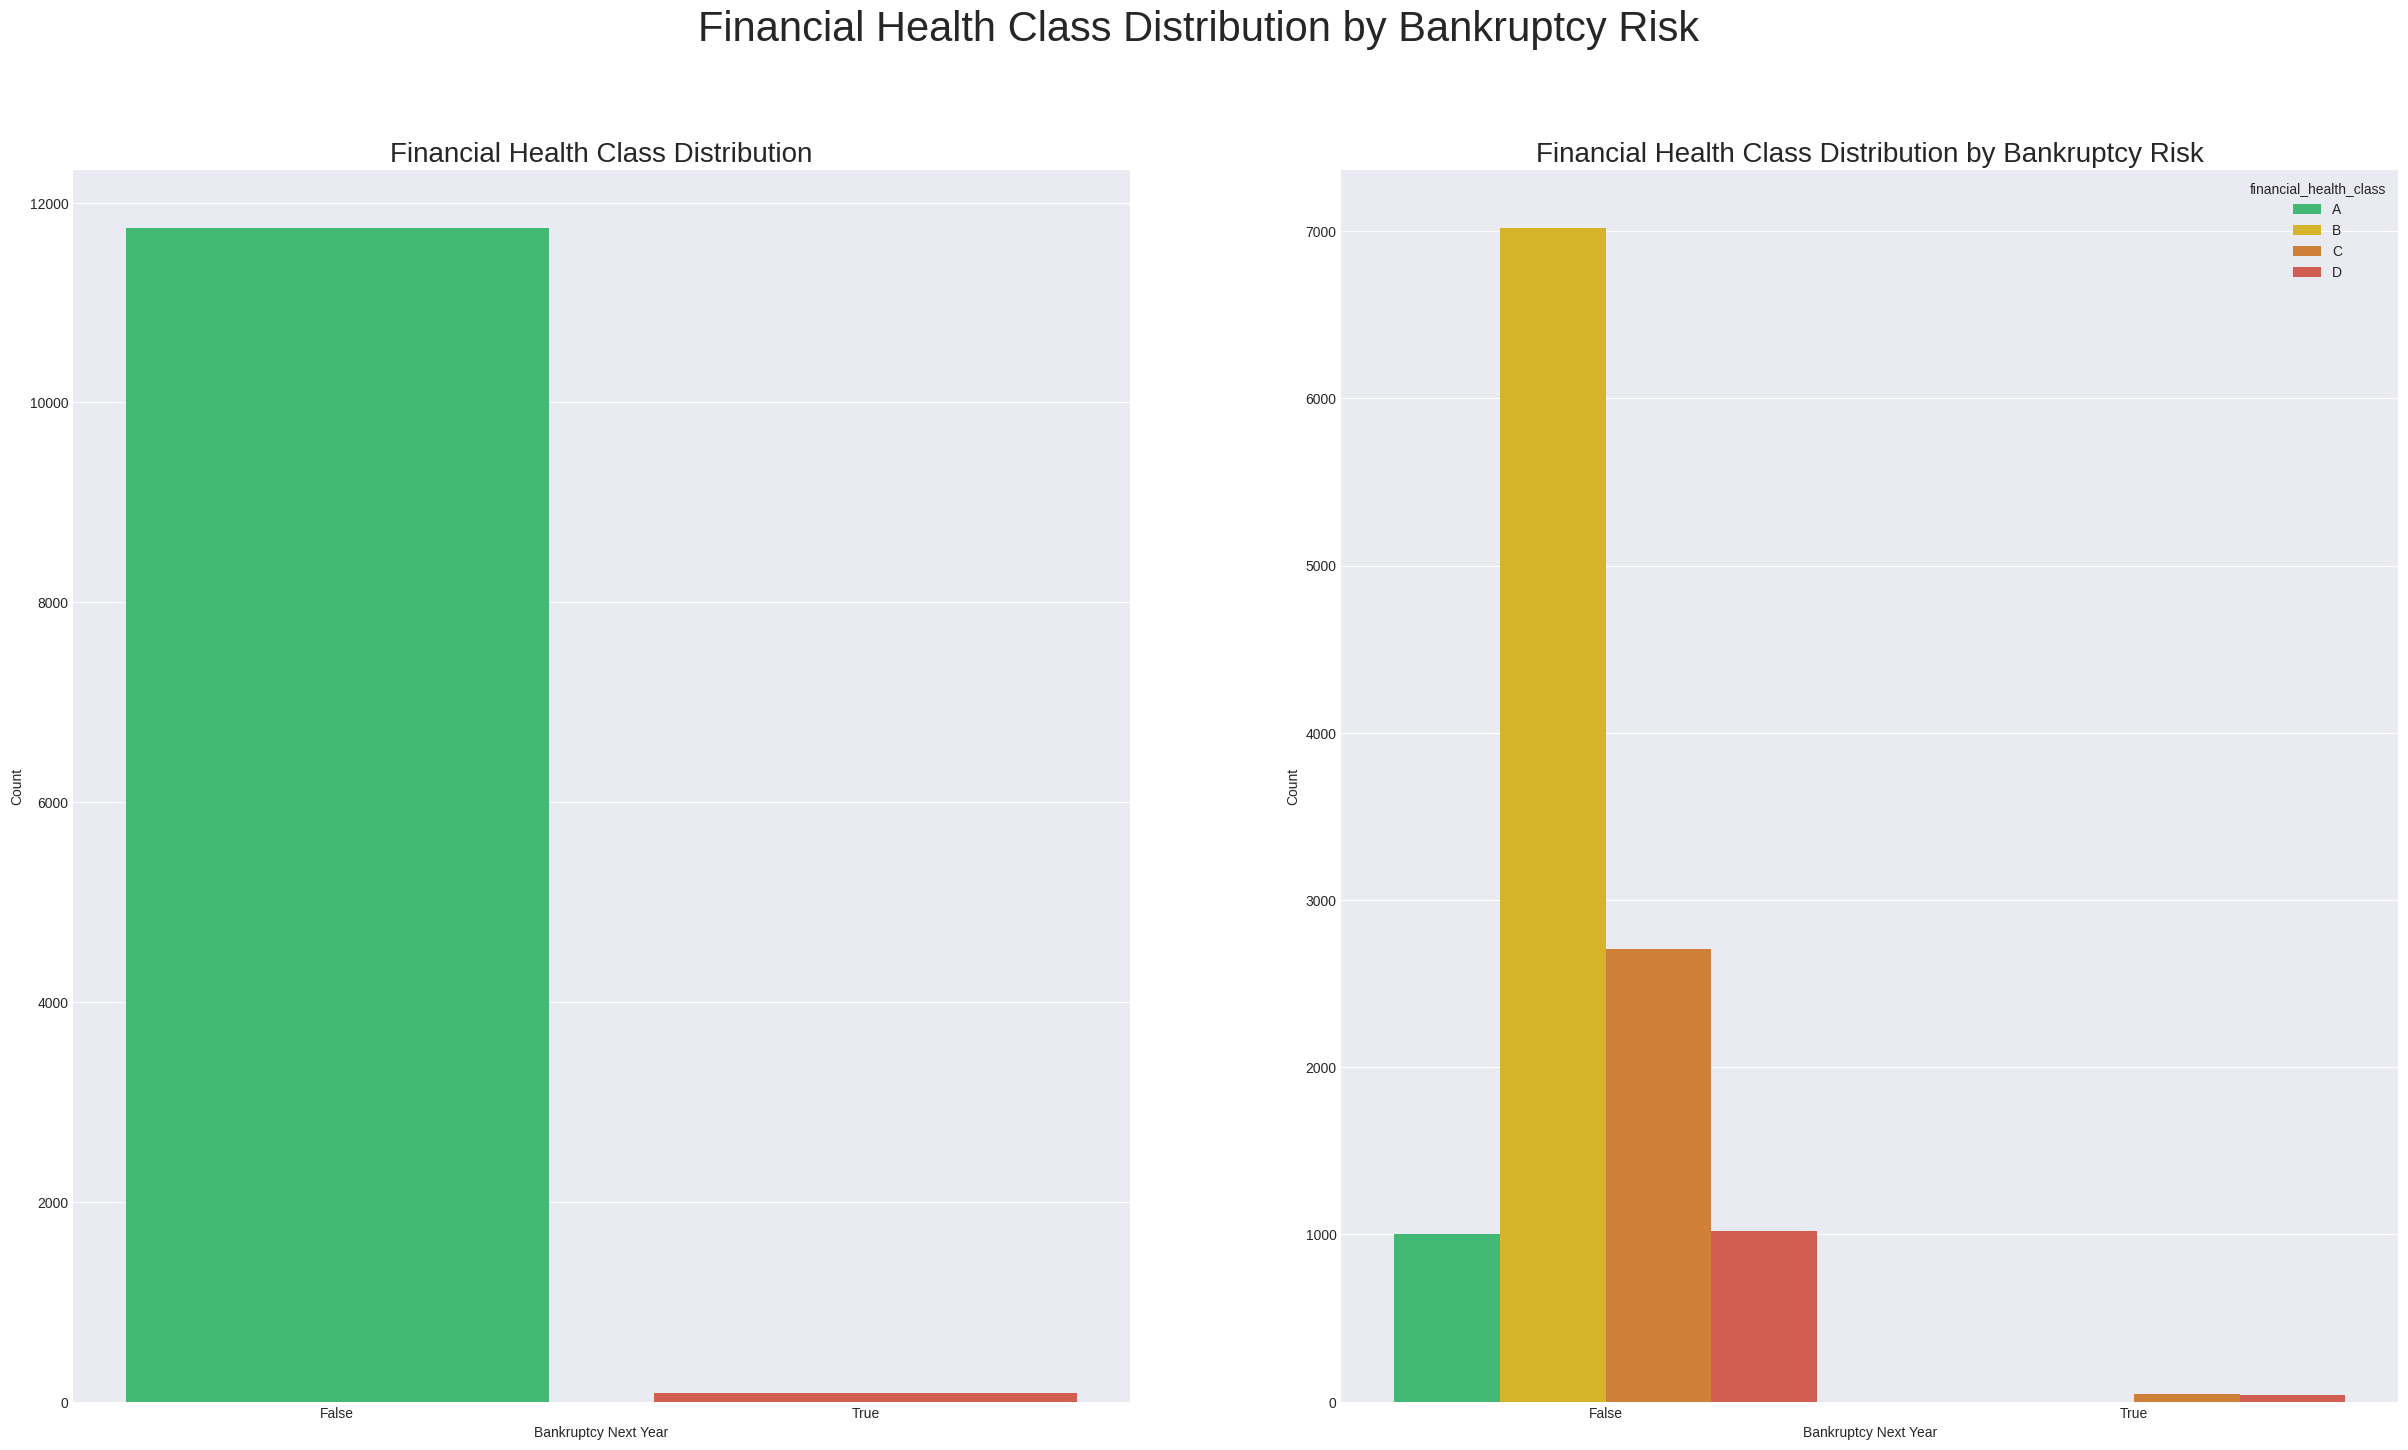

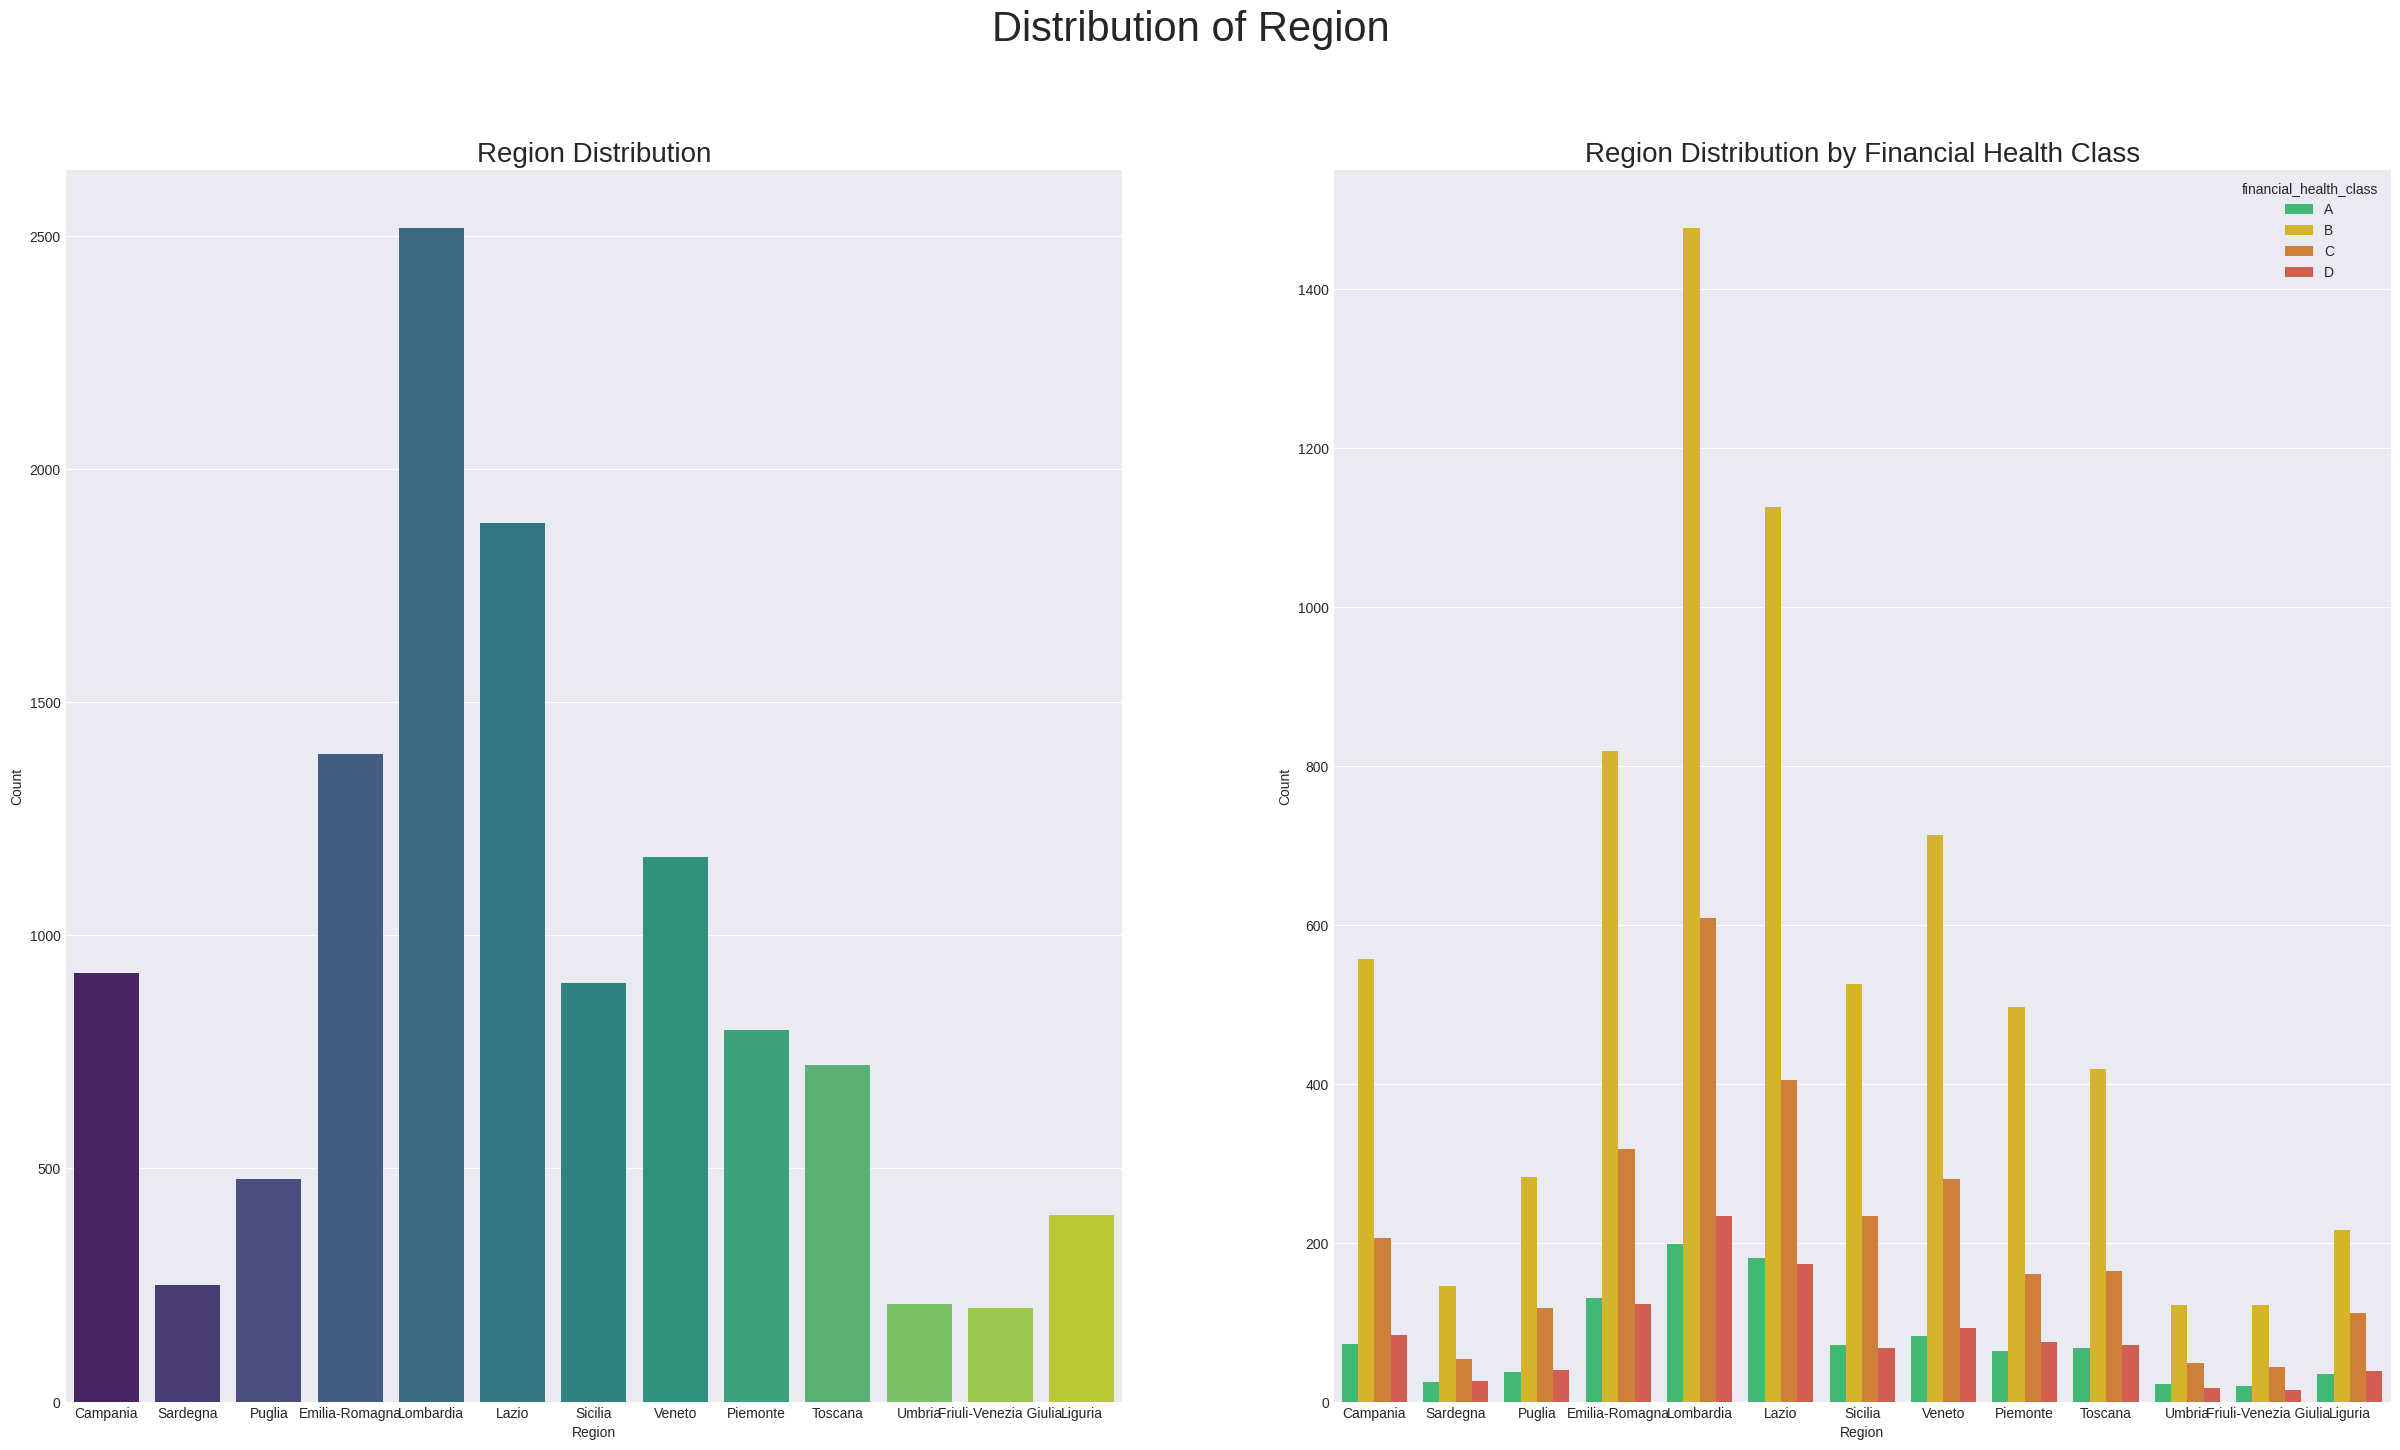

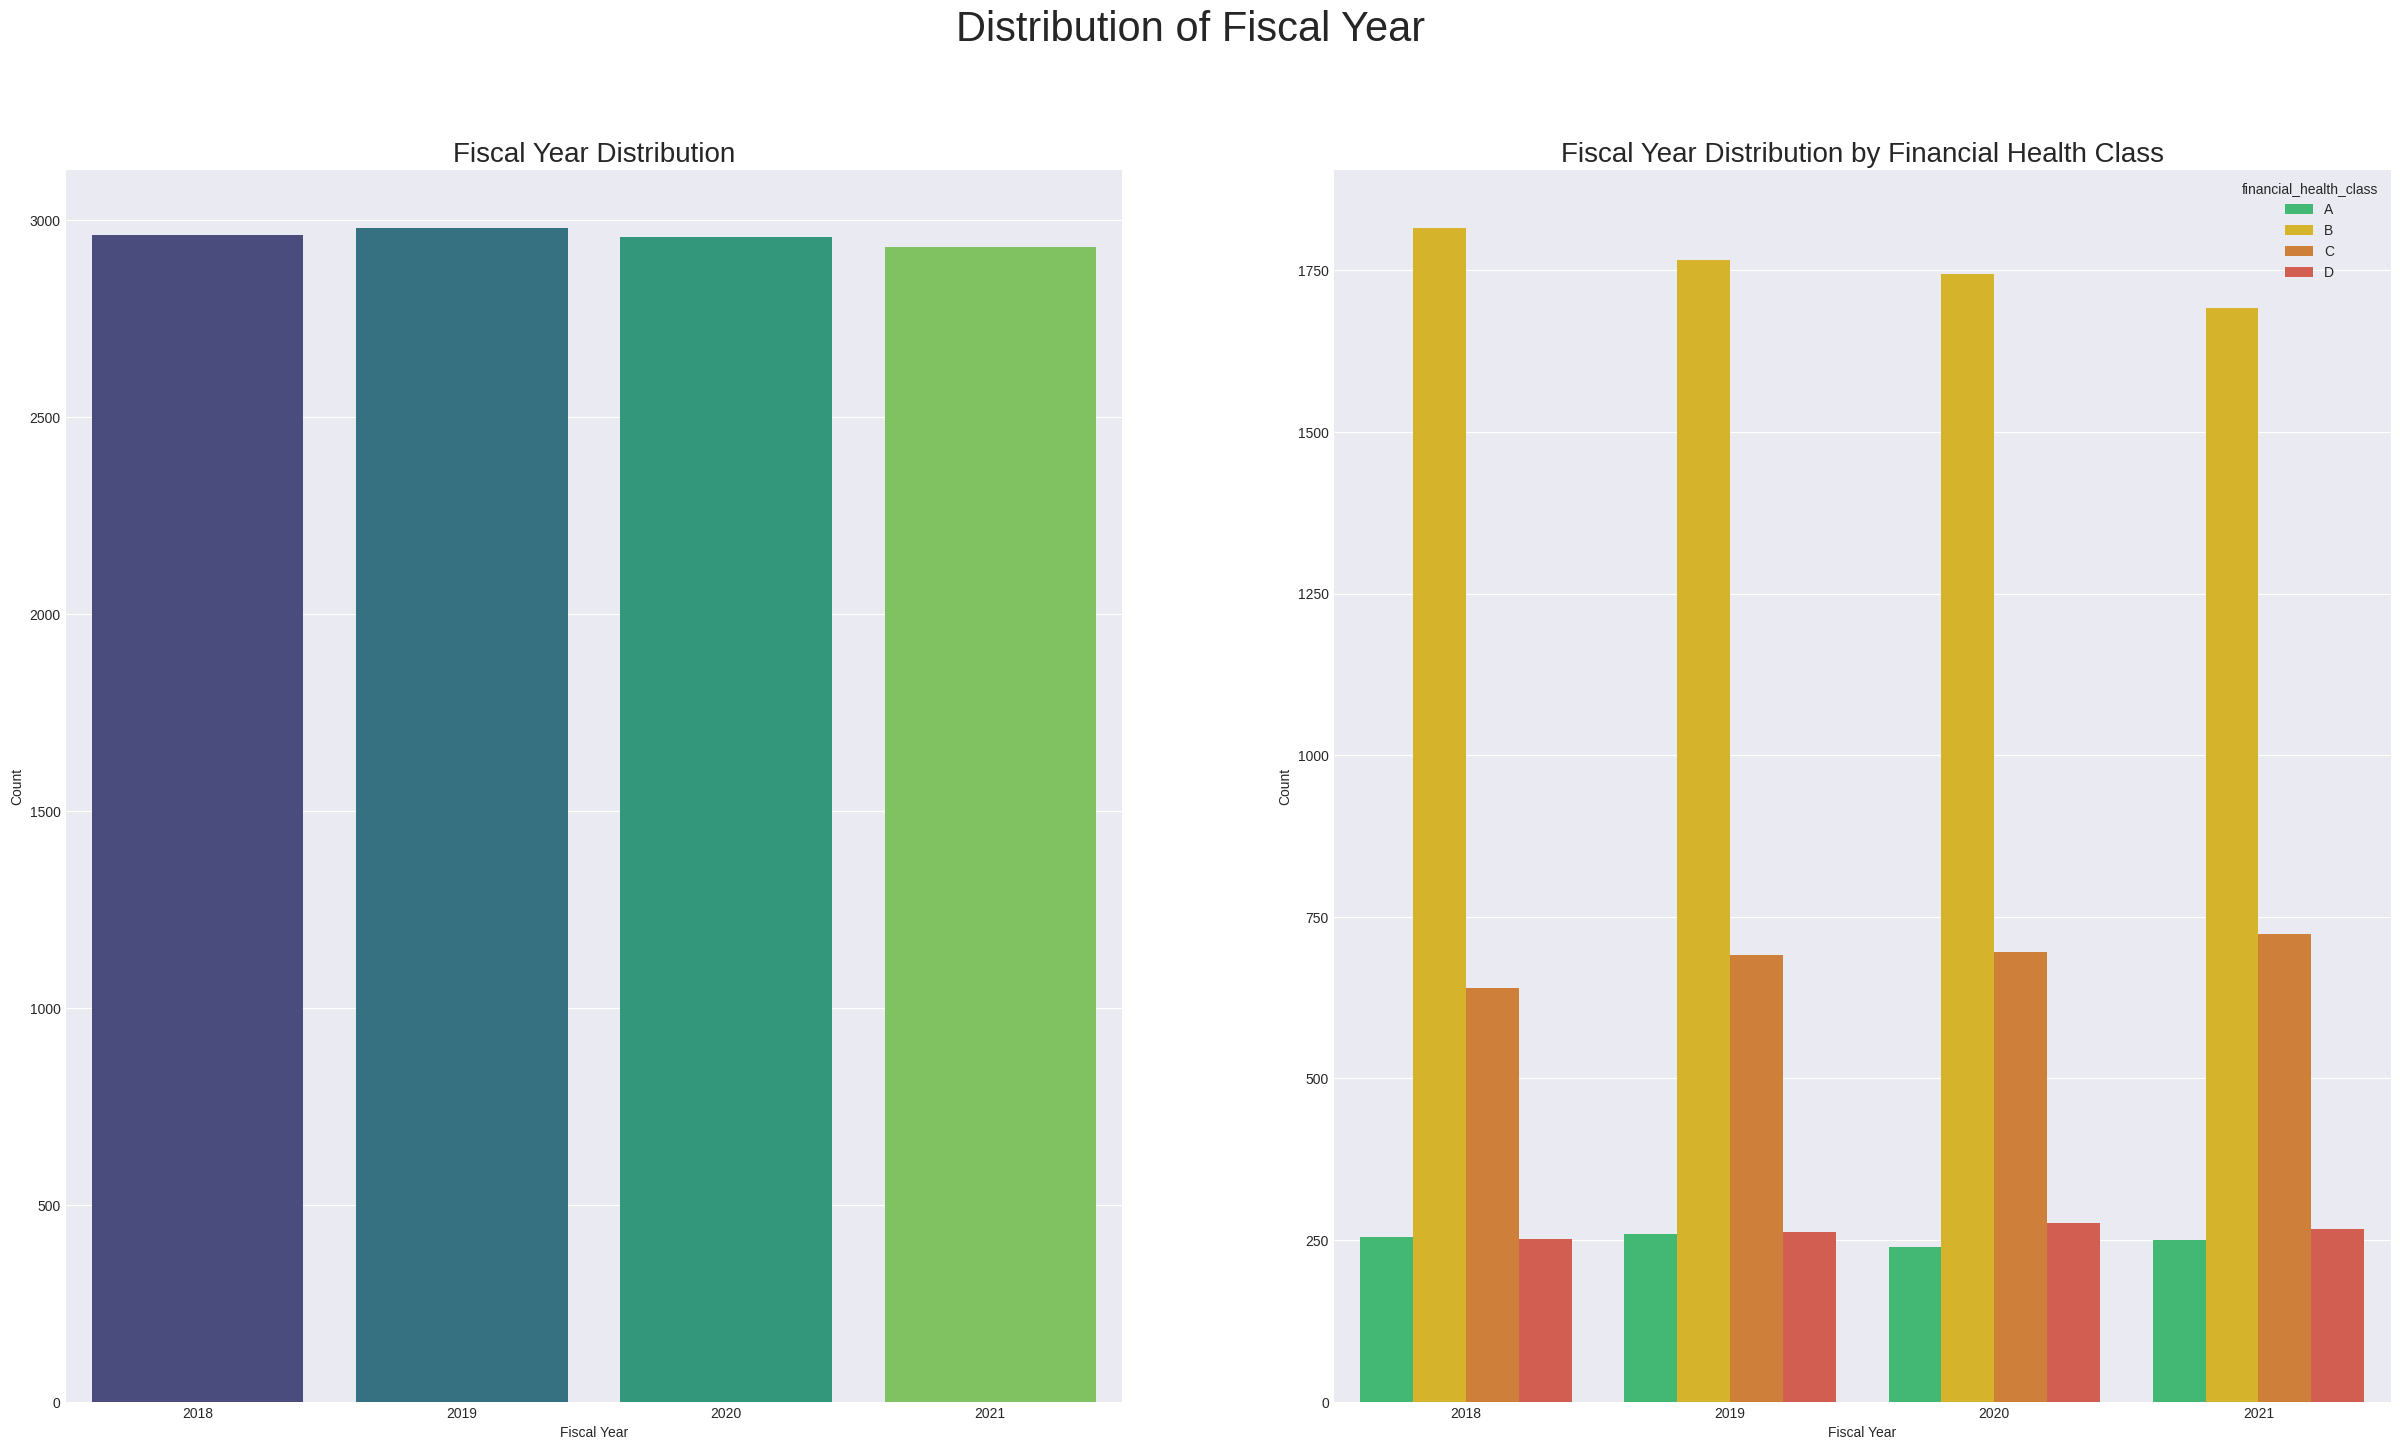

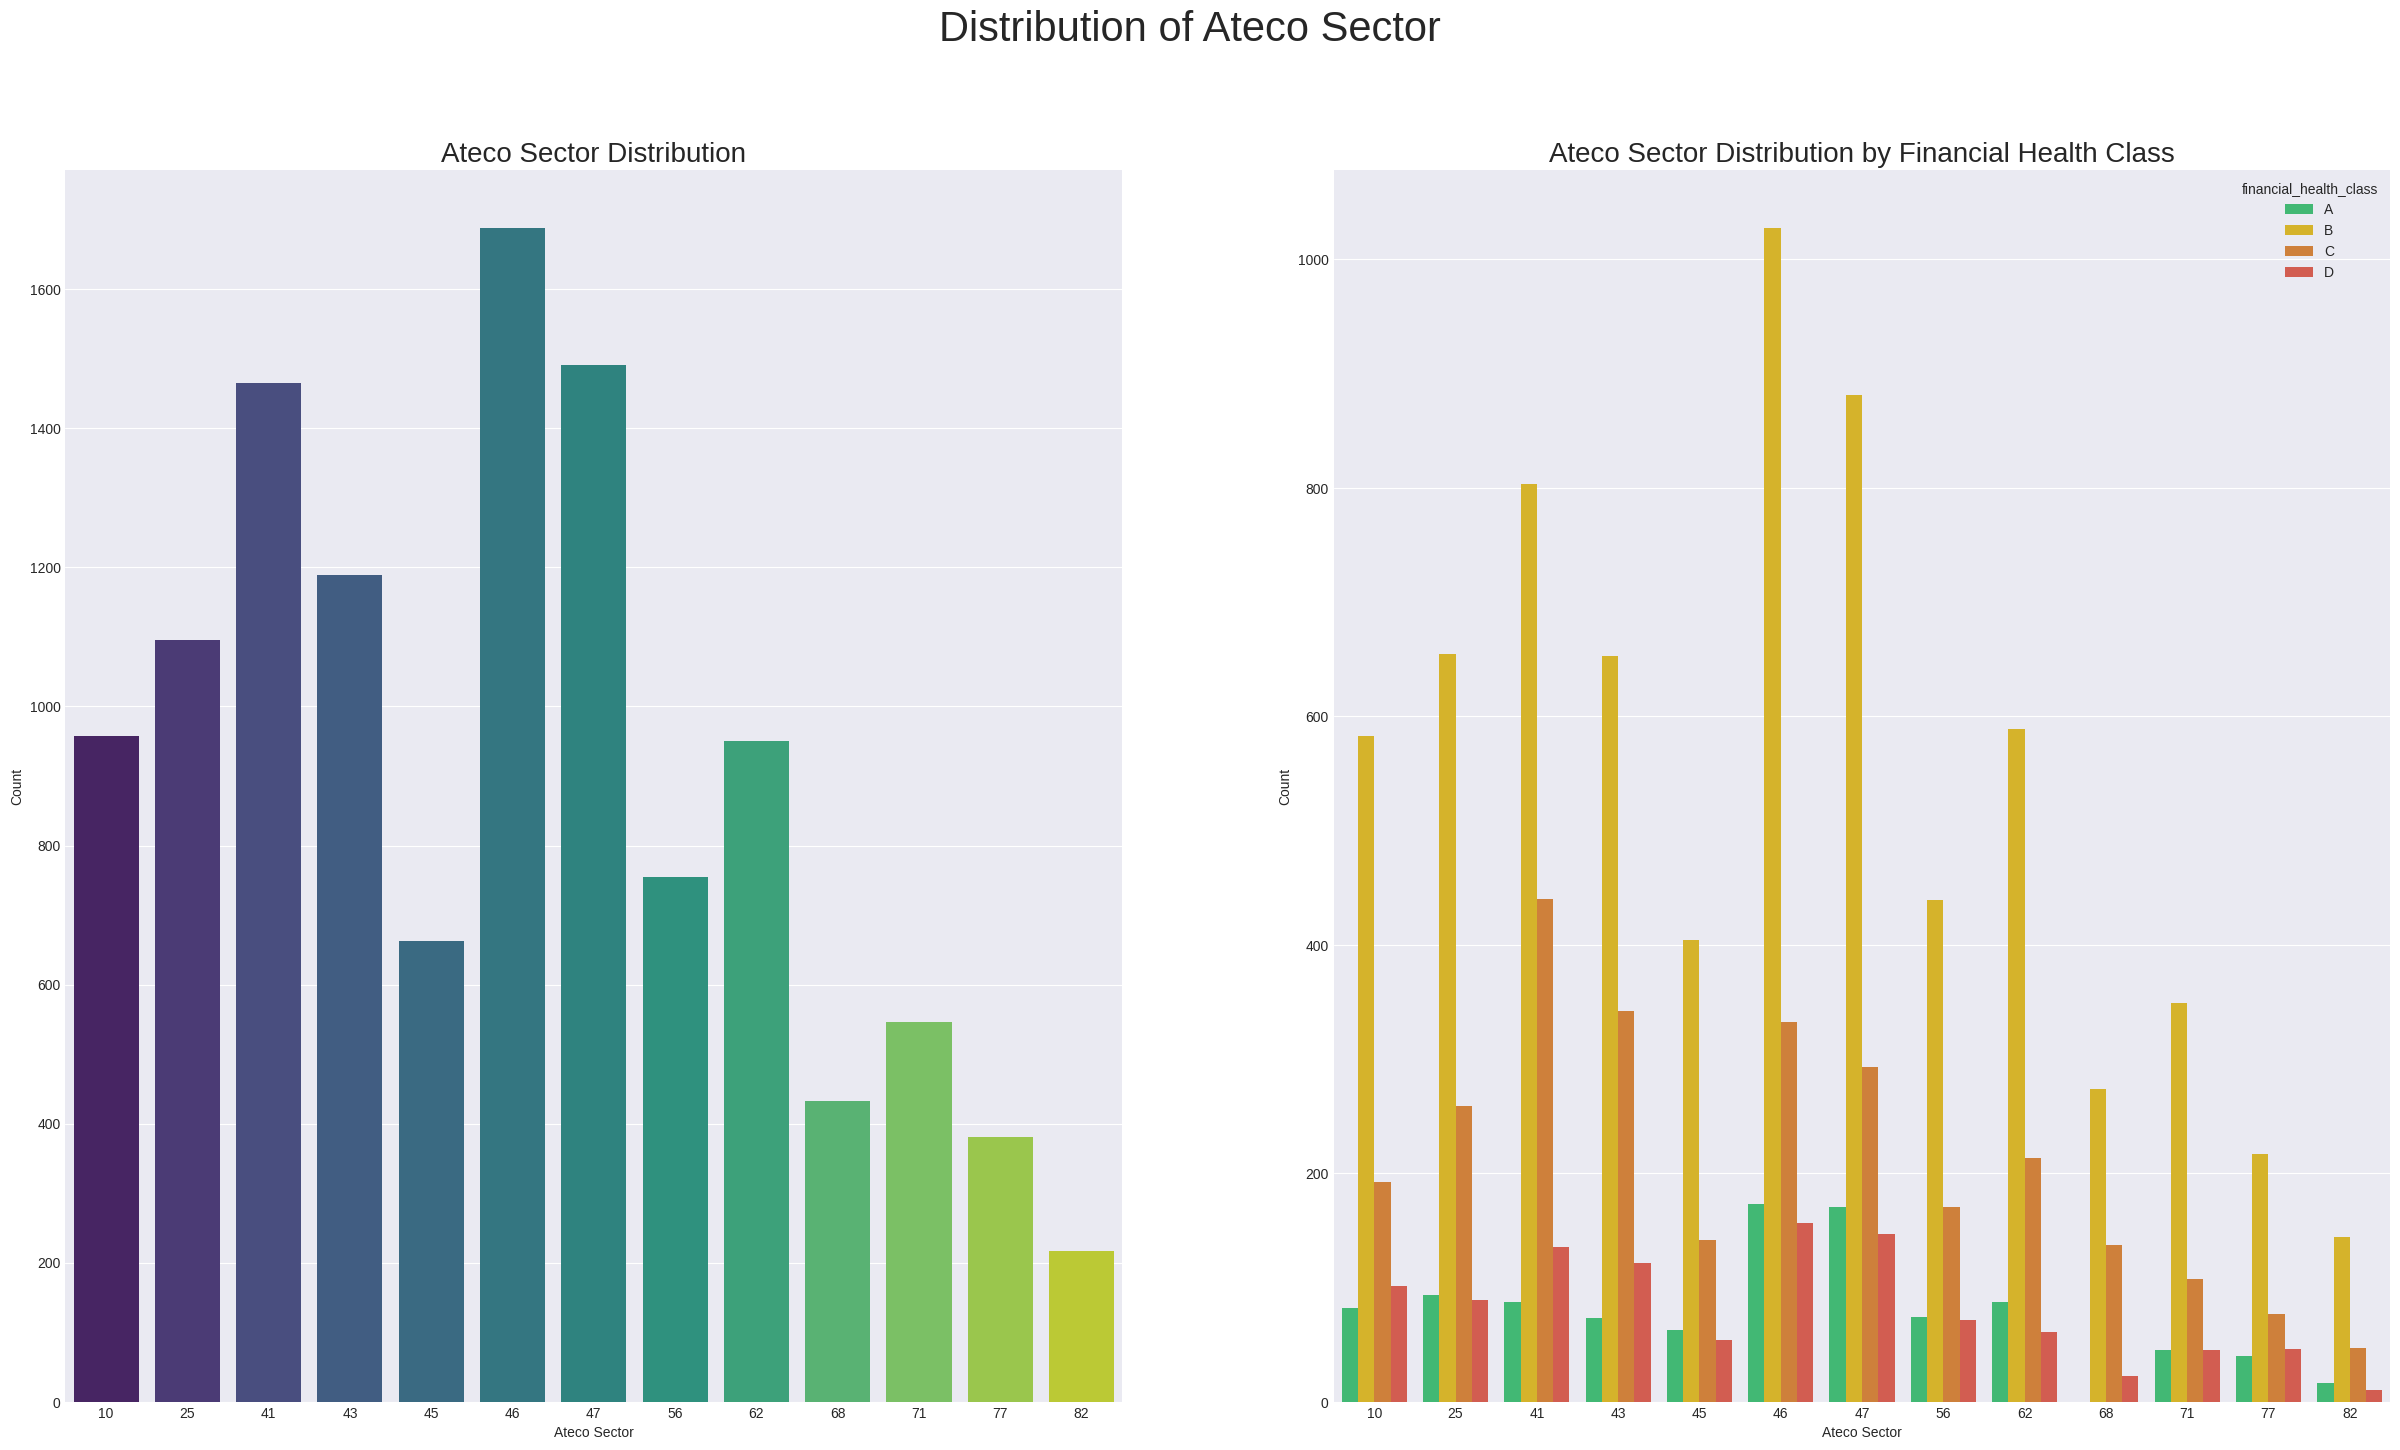

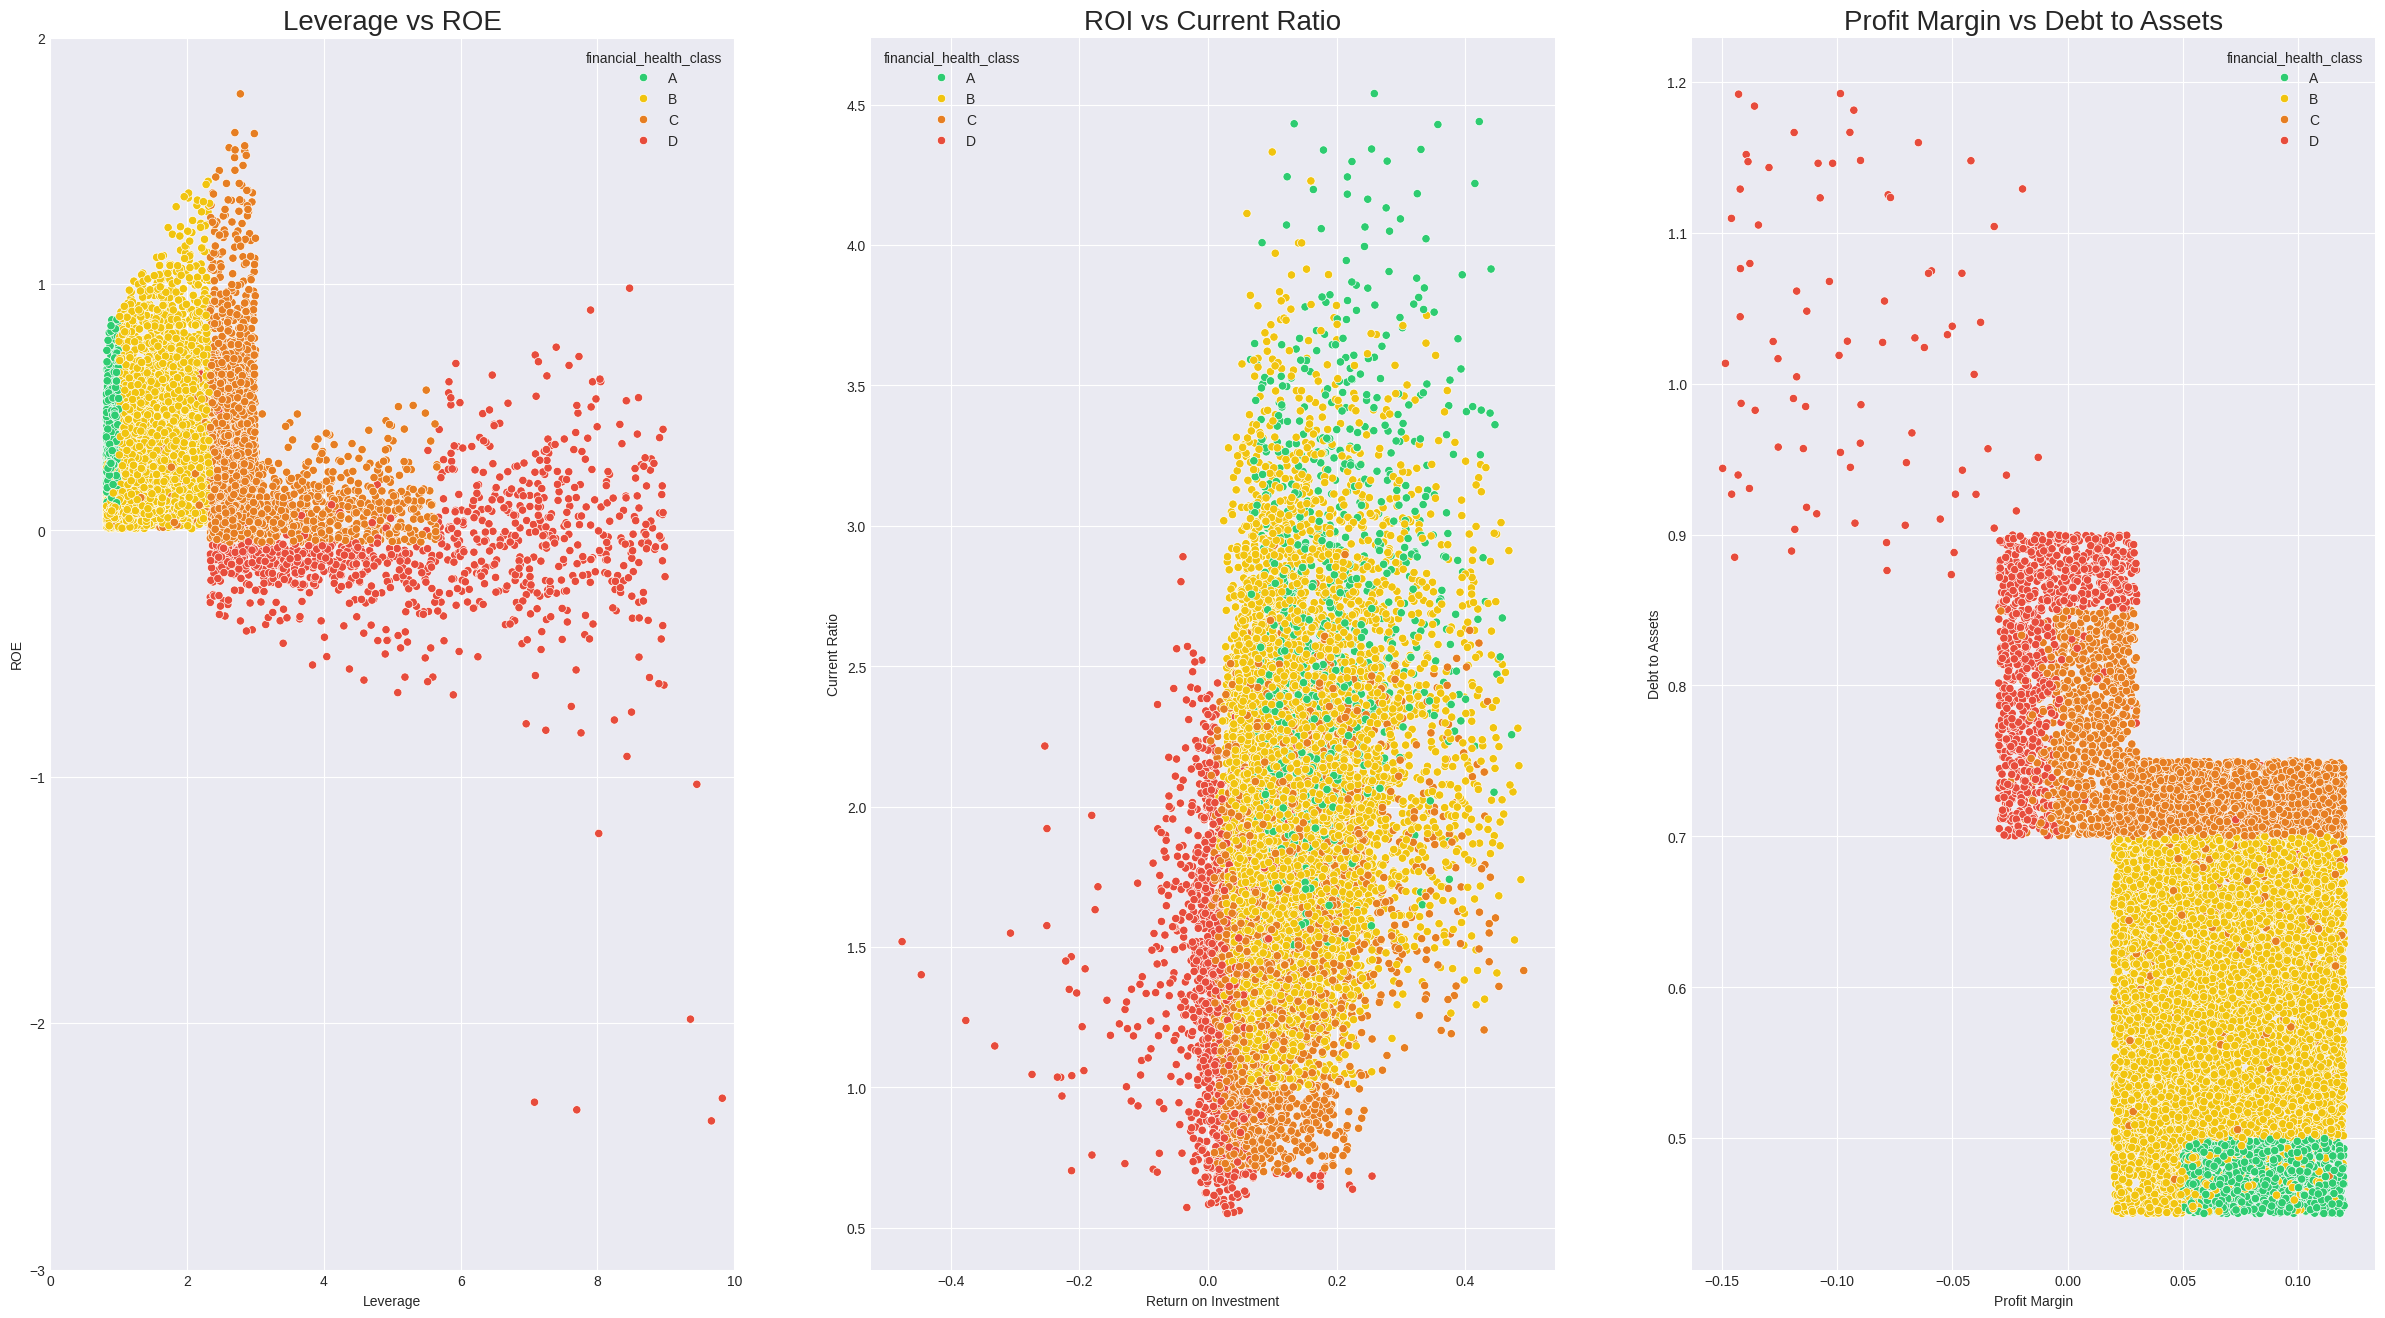

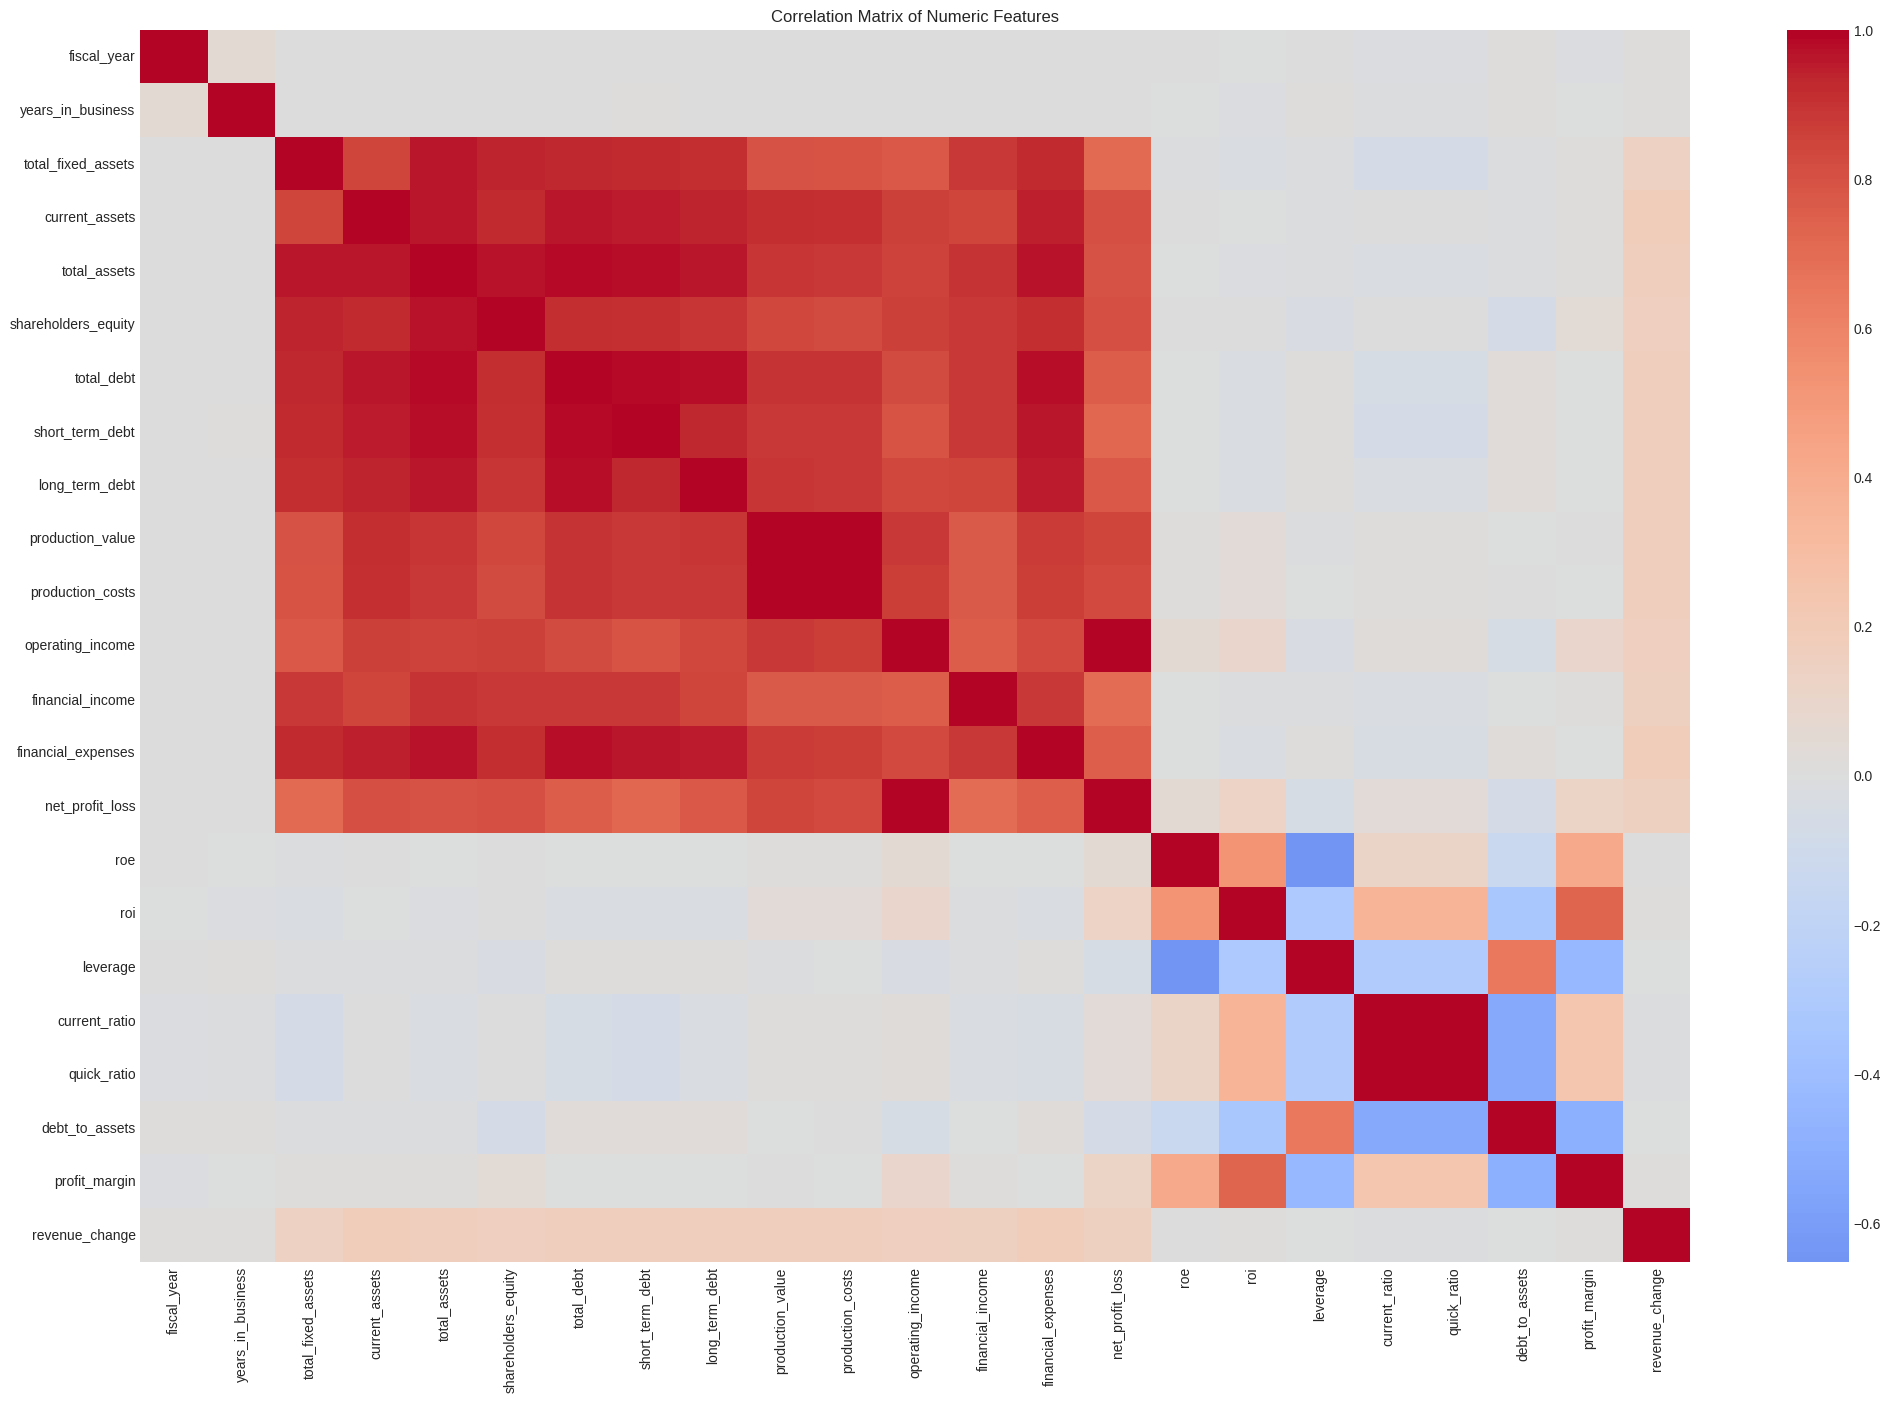

In [ ]:
# TODO: Create visualizations
# - Distribution plots for key financial ratios

## Here we will create boxplots for key financial ratios to visualize their distributions globally and by financial health class.
# Liquidity ratios
fig, axes = plt.subplots(2, 2, figsize=(30, 16))
fig.suptitle('Liquidity Ratios Distribution', fontsize=30)

# Global distribution: Current Ratio
sns.boxplot(y='current_ratio', data=train_df, ax=axes[0,0], color="#EBE4C8")
axes[0,0].set_title('Current Ratio (Global)', fontsize=20)
axes[0,0].set_xlabel('')
axes[0,0].set_ylabel('Current Ratio')

# Global distribution: Quick Ratio
sns.boxplot(y='quick_ratio', data=train_df, ax=axes[0,1], color="#EBE4C8")
axes[0,1].set_title('Quick Ratio (Global)', fontsize=20)
axes[0,1].set_xlabel('')
axes[0,1].set_ylabel('Quick Ratio')

# By class: Current Ratio
sns.boxplot(
    x='financial_health_class', y='current_ratio',
    data=train_df, order=["A", "B", "C", "D"],
    palette=['#2ecc71', '#f1c40f', '#e67e22', '#e74c3c'],
    ax=axes[1,0]
)
axes[1,0].set_title('Current Ratio by Class', fontsize=20)
axes[1,0].set_xlabel('Financial Health Class')
axes[1,0].set_ylabel('')

# By class: Quick Ratio
sns.boxplot(
    x='financial_health_class', y='quick_ratio',
    data=train_df, order=["A", "B", "C", "D"],
    palette=['#2ecc71', '#f1c40f', '#e67e22', '#e74c3c'],
    ax=axes[1,1]
)
axes[1,1].set_title('Quick Ratio by Class', fontsize=20)
axes[1,1].set_xlabel('Financial Health Class')
axes[1,1].set_ylabel('')
plt.show()

# Leverage ratios
fig, axes = plt.subplots(2,2, figsize=(30, 16))
fig.suptitle('Leverage Ratios Distribution', fontsize=30)

# Global distribution: Leverage
sns.boxplot(y='leverage', data=train_df, ax=axes[0,0], color="#EBE4C8")
axes[0,0].set_yscale('log')
axes[0,0].set_title('Leverage (Global)', fontsize=20)
axes[0,0].set_xlabel('')
axes[0,0].set_ylabel('Leverage')

# Global distribution: Debt to Assets
sns.boxplot(y='debt_to_assets', data=train_df, ax=axes[0,1], color="#EBE4C8")
axes[0,1].set_title('Debt to Assets (Global)', fontsize=20)
axes[0,1].set_xlabel('')
axes[0,1].set_ylabel('Debt to Assets')

# By class: Leverage
sns.boxplot(
    x='financial_health_class', y='leverage',
    data=train_df, order=["A", "B", "C", "D"],
    palette=['#2ecc71', '#f1c40f', '#e67e22', '#e74c3c'],
    ax=axes[1,0]
)
axes[1,0].set_yscale('log')
axes[1,0].set_title('Leverage by Class', fontsize=20)
axes[1,0].set_xlabel('Financial Health Class')
axes[1,0].set_ylabel('')

# By class: Debt to Assets
sns.boxplot(
    x='financial_health_class', y='debt_to_assets',
    data=train_df, order=["A", "B", "C", "D"],
    palette=['#2ecc71', '#f1c40f', '#e67e22', '#e74c3c'],
    ax=axes[1,1]
)
axes[1,1].set_title('Debt to Assets by Class', fontsize=20)
axes[1,1].set_xlabel('Financial Health Class')
axes[1,1].set_ylabel('')
plt.show()

# Profitability ratios
fig, axes = plt.subplots(2, 3, figsize=(30, 16))
fig.suptitle('Profitability Ratios Distribution', fontsize=30)

# Global distribution: ROE
sns.boxplot(y='roe', data=train_df, ax=axes[0,0], color="#EBE4C8")
axes[0,0].set_ylim(-2, 2)
axes[0,0].set_title('ROE (Global)', fontsize=20)
axes[0,0].set_xlabel('')
axes[0,0].set_ylabel('Return on Equity')

# Global distribution: ROI
sns.boxplot(y='roi', data=train_df, ax=axes[0,1], color="#EBE4C8")
axes[0,1].set_title('ROI (Global)', fontsize=20)
axes[0,1].set_xlabel('')
axes[0,1].set_ylabel('Return on Investment')

# Global distribution: profit margin
sns.boxplot(y='profit_margin', data=train_df, ax=axes[0,2], color="#EBE4C8")
axes[0,2].set_title('Profit Margin (Global)', fontsize=20)
axes[0,2].set_xlabel('')
axes[0,2].set_ylabel('Profit Margin')

# By class: ROE
sns.boxplot(
    x='financial_health_class', y='roe',
    data=train_df, order=["A", "B", "C", "D"],
    palette=['#2ecc71', '#f1c40f', '#e67e22', '#e74c3c'],
    ax=axes[1,0]
)
axes[1,0].set_ylim(-2, 2)
axes[1,0].set_title('ROE by Class', fontsize=20)
axes[1,0].set_xlabel('Financial Health Class')
axes[1,0].set_ylabel('')

# By class: ROI
sns.boxplot(
    x='financial_health_class', y='roi',
    data=train_df, order=["A", "B", "C", "D"],
    palette=['#2ecc71', '#f1c40f', '#e67e22', '#e74c3c'],
    ax=axes[1,1]
)
axes[1,1].set_title('ROI by Class', fontsize=20)
axes[1,1].set_xlabel('Financial Health Class')
axes[1,1].set_ylabel('')

# By class: Profit Margin
sns.boxplot(
    x='financial_health_class', y='profit_margin',
    data=train_df, order=["A", "B", "C", "D"],
    palette=['#2ecc71', '#f1c40f', '#e67e22', '#e74c3c'],
    ax=axes[1,2]
)
axes[1,2].set_title('Profit Margin by Class', fontsize=20)
axes[1,2].set_xlabel('Financial Health Class')
axes[1,2].set_ylabel('')
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(30, 16))
fig.suptitle('Bankruptcy risk distribution', fontsize=30)
sns.countplot(x='bankruptcy_next_year',  data=train_df, ax=axes[0], palette=['#2ecc71', '#e74c3c'])
axes[0].set_title('Financial Health Class Distribution', fontsize=20)
axes[0].set_xlabel('Bankruptcy Next Year')
axes[0].set_ylabel('Count')
fig.suptitle('Financial Health Class Distribution by Bankruptcy Risk', fontsize=30)
sns.countplot(x='bankruptcy_next_year', hue='financial_health_class', hue_order=["A", "B", "C", "D"], data=train_df, ax=axes[1], palette=['#2ecc71', '#f1c40f', '#e67e22', '#e74c3c'])
axes[1].set_title('Financial Health Class Distribution by Bankruptcy Risk', fontsize=20)
axes[1].set_xlabel('Bankruptcy Next Year')
axes[1].set_ylabel('Count')
plt.show()

# After looking at the ditstribution of key financial ratios, we wanted to analyze the distribution of other variables like  region, fiscal year and ateco code. We will create countplots for these variables to see how they are distributed across the dataset and if there are any noticeable patterns or imbalances.
fig, axes = plt.subplots(1, 2, figsize=(30, 16))
fig.suptitle('Distribution of Region', fontsize=30)

# Global distribution: Region
sns.countplot(x='region', data=train_df, ax=axes[0], palette="viridis")
axes[0].set_title('Region Distribution', fontsize=20)
axes[0].set_xlabel('Region')
axes[0].set_ylabel('Count')

# By class: Region
sns.countplot(x='region', hue='financial_health_class', hue_order=["A", "B", "C", "D"], data=train_df, ax=axes[1], palette=['#2ecc71', '#f1c40f', '#e67e22', '#e74c3c'])
axes[1].set_title('Region Distribution by Financial Health Class', fontsize=20)
axes[1].set_xlabel('Region')
axes[1].set_ylabel('Count')
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(30, 16))
fig.suptitle('Distribution of Fiscal Year', fontsize=30)

# Global distribution: Year distribution
sns.countplot(x='fiscal_year', data=train_df, ax=axes[0], palette="viridis")
axes[0].set_title('Fiscal Year Distribution', fontsize=20)
axes[0].set_xlabel('Fiscal Year')
axes[0].set_ylabel('Count')

# By class: Fiscal Year
sns.countplot(x='fiscal_year', hue='financial_health_class', hue_order=["A", "B", "C", "D"], data=train_df, ax=axes[1], palette=['#2ecc71', '#f1c40f', '#e67e22', '#e74c3c'])
axes[1].set_title('Fiscal Year Distribution by Financial Health Class', fontsize=20)
axes[1].set_xlabel('Fiscal Year')
axes[1].set_ylabel('Count')
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(30, 16))
fig.suptitle('Distribution of Ateco Sector', fontsize=30)

# Global distribution: Ateco code distribution
sns.countplot(x='ateco_sector', data=train_df, ax=axes[0], palette="viridis")
axes[0].set_title('Ateco Sector Distribution', fontsize=20)
axes[0].set_xlabel('Ateco Sector')
axes[0].set_ylabel('Count')

# By class: Ateco sector
sns.countplot(x='ateco_sector', hue='financial_health_class', hue_order=["A", "B", "C", "D"], data=train_df, ax=axes[1], palette=['#2ecc71', '#f1c40f', '#e67e22', '#e74c3c'])
axes[1].set_title('Ateco Sector Distribution by Financial Health Class', fontsize=20)
axes[1].set_xlabel('Ateco Sector')
axes[1].set_ylabel('Count')
plt.show()

# Scatterplots between key financial ratios to see if there are any relationships or clusters that could be indicative of
# Financial health classes. We will create scatterplots for pairs of ratios like ROE vs ROI, Current Ratio vs Quick Ratio, and Leverage vs Debt to Assets, colored by financial health class to visualize any potential patterns.
fig.suptitle('Correlation between Key Financial Ratios', fontsize=30)

# Leverage vs ROE
fig, axes = plt.subplots(1, 3, figsize=(30, 16))
sns.scatterplot(x='leverage', y='roe', hue='financial_health_class', hue_order=["A", "B", "C", "D"], data=train_df, palette=['#2ecc71', '#f1c40f', '#e67e22', '#e74c3c'], ax=axes[0])
axes[0].set_title('Leverage vs ROE', fontsize=20)
axes[0].set_xlabel('Leverage')

# We set the limit of x to 25 to better visualize the data since there are some extreme values in leverage that could skew the plot.
axes[0].set_xlim(0, 10)
axes[0].set_ylabel('ROE')
axes[0].set_ylim(-3,2)

# ROI vs current ratio
sns.scatterplot(x='roi', y='current_ratio', hue='financial_health_class', hue_order=["A", "B", "C", "D"], data=train_df, palette=['#2ecc71', '#f1c40f', '#e67e22', '#e74c3c'], ax=axes[1])
axes[1].set_title('ROI vs Current Ratio', fontsize=20)
axes[1].set_xlabel('Return on Investment')
axes[1].set_ylabel('Current Ratio')

# Profit margin vs debt to assets
sns.scatterplot(x='profit_margin', y='debt_to_assets', hue='financial_health_class', hue_order=["A", "B", "C", "D"], data=train_df, palette=['#2ecc71', '#f1c40f', '#e67e22', '#e74c3c'], ax=axes[2])
axes[2].set_title('Profit Margin vs Debt to Assets', fontsize=20)
axes[2].set_xlabel('Profit Margin')
axes[2].set_ylabel('Debt to Assets')
plt.show()

# Correlation matrix
numeric_cols = train_df.select_dtypes(include=[np.number]).columns
correlation_matrix = train_df[numeric_cols].corr()

plt.figure(figsize=(25, 16))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Numeric Features')
plt.show()

**Key Insights from EDA:**

TODO: Document your key findings
-
-
-

## 3. Data Preprocessing

Handle missing values, outliers, and prepare data for modeling.

In [ ]:
# Eliminate all insignificant features
print(unsignificant_numerical_features)
print(unsignificant_categorical_features)
unsignificant_features=unsignificant_categorical_features + unsignificant_numerical_features
df_train= train_df.drop(columns=unsignificant_features)

['short_term_debt', 'total_debt', 'years_in_business', 'long_term_debt', 'current_assets', 'financial_expenses', 'total_fixed_assets', 'production_value', 'total_assets', 'financial_income', 'production_costs', 'fiscal_year', 'revenue_change']
['province', 'region', 'legal_form']


In [ ]:
# Create a copy for preprocessing
df_processed = train_df.copy()

# TODO: Handle missing values
# - Decide on imputation strategy (median, mean, by group, etc.)
def impute_with_group(df, target_col, group_cols, is_categorical = False):
    df = df.copy()

    # Create a dummy for the missing values
    dummy_col = f"{target_col}_missing"
    df[dummy_col] = df[target_col].isna().astype(int)

    # Check whether we have a categorical or a numerical column
    if is_categorical == False:
        # Numerical case
        group_stats = df.groupby(group_cols)[target_col].agg(median="median", observations="count")
        print(f"\nGroups with NaN in {target_col}:")
        print(group_stats[group_stats["median"].isna()])

        # Imputate using the median
        group_values = df.groupby(group_cols)[target_col].transform("median")
    elif is_categorical == True:
        # Categorical case
        group_stats = df.groupby(group_cols)[target_col].agg(observations="count")
        print(f"\nGroups with NaN in {target_col} (categorical column):")
        # Stampa solo i gruppi con NaN
        # Pure sto codice è sus ???
        nan_groups = df[df[target_col].isna()].groupby(group_cols).size().reset_index(name="n_missing")
        print(nan_groups if not nan_groups.empty else "None")

        # Imputate using mode
        # Che cazzo è sto codice CAMBIALO ???
        group_values = df.groupby(group_cols)[target_col].transform(
            lambda x: x.mode().iloc[0] if not x.mode().empty else None
        )

    # Imputation
    df[target_col] = df[target_col].fillna(group_values)

    # Check for eventual NaNs
    n_missing = df[target_col].isna().sum()
    print(f"Number of NaNs after imputation for {target_col}: {n_missing}\n")

    return df

# ROE
df_processed = impute_with_group(df_processed, target_col="roe", group_cols=["legal_form", "fiscal_year", "ateco_sector"])

# Leverage CONTROLLA SE è GIUSTO IN BASE ALLA FORMULA
df_processed = impute_with_group(df_processed, target_col="leverage", group_cols=["legal_form", "fiscal_year", "ateco_sector"])

# Revenue change CONTROLLA SE è GIUSTO IN BASE ALLA FORMULA
df_processed = impute_with_group(df_processed, target_col="revenue_change", group_cols=["legal_form", "ateco_sector"])

# Region
df_processed = impute_with_group(df_processed, target_col="province", group_cols=["region"], is_categorical = True)

# - Document your rationale


# TODO: Handle outliers
# - Identify outliers (IQR, winsorization, etc.)
# First quartile
first_quartile = df_processed.quantile(q=0.25, numeric_only=True)
print("FIRST QUARTILE:")
print(f"{first_quartile}\n")

# Third quartile
third_quartile = df_processed.quantile(q=0.75, numeric_only=True)
print("THIRD QUARTILE:")
print(f"{third_quartile}\n")

# IQR
IQR = third_quartile-first_quartile
print("IQR:")
print(f"{IQR}\n")

# Outlier threshold
lower_threshold = first_quartile - (1.5 * IQR)
upper_threshold = third_quartile + (1.5 * IQR)
print(lower_threshold)
print(upper_threshold)

#Identifing outliers
outliers = df_processed[((df_processed.select_dtypes(include="number") < lower_threshold) | (df_processed.select_dtypes(include="number") > upper_threshold))]
print(outliers)
# - Decide on treatment strategy
numeric_cols = df_processed.select_dtypes(include="number").columns

# Compute percentile bounds
lower_bound = df_processed[numeric_cols].quantile(0.01)
upper_bound = df_processed[numeric_cols].quantile(0.99)

# Apply winsorization
df_winsorized = df_processed.copy()
df_winsorized[numeric_cols] = df_processed[numeric_cols].clip(lower=lower_bound, upper=upper_bound, axis=1)
display(df_winsorized)

# TODO: Encode categorical variables
# - One-hot encoding, label encoding, etc.
categorical_cols = df_winsorized.select_dtypes(include="object").columns.tolist()
categorical_cols = [c for c in categorical_cols if c not in ["company_id", "financial_health_class"]]
df_winsorized = pd.get_dummies(df_winsorized, columns=categorical_cols, drop_first=True)

print("Preprocessing complete!")
print(df_winsorized.head())


Groups with NaN in roe:
Empty DataFrame
Columns: [median, observations]
Index: []
Number of NaNs after imputation for roe: 0


Groups with NaN in leverage:
Empty DataFrame
Columns: [median, observations]
Index: []
Number of NaNs after imputation for leverage: 0


Groups with NaN in revenue_change:
Empty DataFrame
Columns: [median, observations]
Index: []
Number of NaNs after imputation for revenue_change: 0


Groups with NaN in province (categorical column):
     region  n_missing
0  Campania        919
Number of NaNs after imputation for province: 919

FIRST QUARTILE:
fiscal_year               2.018000e+03
years_in_business         1.800000e+01
total_fixed_assets        7.319803e+07
current_assets            1.244471e+08
total_assets              2.087793e+08
shareholders_equity       7.070428e+07
total_debt                1.294646e+08
short_term_debt           6.925617e+07
long_term_debt            5.666362e+07
production_value          2.984883e+08
production_costs          2.73129

company_id  fiscal_year province          region ateco_sector  \
0      COMP_00000         2018      NaN        Campania           47   
1      COMP_00000         2019      NaN        Campania           47   
2      COMP_00000         2020      NaN        Campania           47   
3      COMP_00000         2021      NaN        Campania           47   
4      COMP_00001         2018       CA        Sardegna           62   
...           ...          ...      ...             ...          ...   
11823  COMP_02998         2021       MI       Lombardia           46   
11824  COMP_02999         2018       MO  Emilia-Romagna           25   
11825  COMP_02999         2019       MO  Emilia-Romagna           25   
11826  COMP_02999         2020       MO  Emilia-Romagna           25   
11827  COMP_02999         2021       MO  Emilia-Romagna           25   

      legal_form  years_in_business  total_fixed_assets  current_assets  \
0            SRL                 32        2.422343e+08    9.504819e+08   
1            SRL                 33        3.983639e+07    1.411226e+08   
2            SRL                 34        6.662250e+08    1.367208e+09   
3            SRL                 35        4.637187e+07    2.524228e+08   
4            SRL                  8        8.348035e+07    1.325697e+08   
...          ...                ...                 ...             ...   
11823        SRL                  4        8.501086e+06    2.085571e+07   
11824        SNC                 43        7.565158e+07    1.781811e+08   
11825        SNC                 44        1.489892e+08    2.692998e+08   
11826        SNC                 45        4.620261e+07    6.941583e+07   
11827        SNC                 46        1.665420e+09    1.819238e+09   

       total_assets  shareholders_equity    total_debt  short_term_debt  \
0      1.192716e+09         3.728702e+08  8.198459e+08     5.601842e+08   
1      1.809589e+08         5.700701e+07  1.239519e+08     7.135345e+07   
2      2.033433e+09         3.029046e+08  1.730529e+09     9.904004e+08   
3      2.987947e+08         3.901098e+07  2.597837e+08     1.527674e+08   
4      2.160500e+08         6.566937e+07  1.503807e+08     7.582482e+07   
...             ...                  ...           ...              ...   
11823  2.826175e+07         1.008540e+07  1.817635e+07     8.562312e+06   
11824  2.538327e+08         5.562373e+07  1.982089e+08     1.369664e+08   
11825  4.182890e+08         1.263133e+08  2.919757e+08     1.512223e+08   
11826  1.156184e+08         3.355098e+07  8.206746e+07     5.407790e+07   
11827  3.484658e+09         9.463607e+08  2.538297e+09     1.503931e+09   

       long_term_debt  production_value  production_costs  operating_income  \
0        2.596617e+08      1.846636e+09      1.611363e+09      2.352729e+08   
1        5.259848e+07      4.289159e+08      3.896038e+08      3.931218e+07   
2        7.401282e+08      6.956197e+09      6.988489e+09     -3.091586e+07   
3        1.070163e+08      5.031839e+08      5.047235e+08     -1.539645e+06   
4        7.455584e+07      4.113380e+08      3.912414e+08      2.009667e+07   
...               ...               ...               ...               ...   
11823    1.062244e+07      9.635711e+07      9.118477e+07      5.172341e+06   
11824    6.124255e+07      3.403019e+08      3.259041e+08      1.439782e+07   
11825    1.407534e+08      8.222183e+08      7.731927e+08      4.902560e+07   
11826    2.798956e+07      1.088995e+08      9.782512e+07      1.107442e+07   
11827    1.034366e+09      4.273608e+09      4.048617e+09      2.249909e+08   

       financial_income  financial_expenses  net_profit_loss     roe     roi  \
0            4886785.12         20068071.29     2.152049e+08  0.5772  0.1973   
1              58246.06          2537224.20     3.677495e+07  0.6451  0.2172   
2            5327332.51         55844558.38    -8.813664e+07 -0.2910 -0.0159   
3             116335.80          7828741.61    -9.368387e+06 -0.2401 -0

Preprocessing complete!
   company_id  fiscal_year  years_in_business  total_fixed_assets  \
0  COMP_00000         2018                 32        2.422343e+08   
1  COMP_00000         2019                 33        3.983639e+07   
2  COMP_00000         2020                 34        6.662250e+08   
3  COMP_00000         2021                 35        4.637187e+07   
4  COMP_00001         2018                  8        8.348035e+07   

   current_assets  total_assets  shareholders_equity    total_debt  \
0    9.504819e+08  1.192716e+09         3.728702e+08  8.198459e+08   
1    1.411226e+08  1.809589e+08         5.700701e+07  1.239519e+08   
2    1.367208e+09  2.033433e+09         3.029046e+08  1.730529e+09   
3    2.524228e+08  2.987947e+08         3.901098e+07  2.597837e+08   
4    1.325697e+08  2.160500e+08         6.566937e+07  1.503807e+08   

   short_term_debt  long_term_debt  production_value  production_costs  \
0     5.601842e+08    2.596617e+08      1.846636e+09      1.611363

In [13]:
# Train/Validation split
# IMPORTANT: Use temporal split, not random!

# For Challenges 1 & 2:
train_years = [2018, 2019, 2020]
val_year = 2021

# TODO: Implement temporal split
df_train = df_winsorized[df_winsorized['fiscal_year'].isin(train_years)]
df_val = df_winsorized[df_winsorized['fiscal_year'] == val_year]

X_train = df_train.drop(columns=["financial_health_class", "company_id"])
y_train = df_train["financial_health_class"]

X_val = df_val.drop(columns=["financial_health_class", "company_id"])
y_val = df_val["financial_health_class"]

print("Training set years:", df_train['fiscal_year'].unique())
print("Validation set year:", df_val['fiscal_year'].unique())
print("Train shape:", df_train.shape, "Validation shape:", df_val.shape)
print("Train/validation split complete!")

Training set years: [2018 2019 2020]
Validation set year: [2021]
Train shape: (8896, 76) Validation shape: (2932, 76)
Train/validation split complete!


In [14]:
print(X_train.dtypes)           # Check column types
print(X_train.isnull().sum())   # Check for missing values
print(X_train.head())

fiscal_year                       int64
years_in_business                 int64
total_fixed_assets              float64
current_assets                  float64
total_assets                    float64
shareholders_equity             float64
total_debt                      float64
short_term_debt                 float64
long_term_debt                  float64
production_value                float64
production_costs                float64
operating_income                float64
financial_income                float64
financial_expenses              float64
net_profit_loss                 float64
roe                             float64
roi                             float64
leverage                        float64
current_ratio                   float64
quick_ratio                     float64
debt_to_assets                  float64
profit_margin                   float64
revenue_change                  float64
roe_missing                       int64
leverage_missing                  int64


In [15]:
# Feature scaling
# IMPORTANT: Fit scaler on training data only!

from sklearn.preprocessing import StandardScaler, RobustScaler

# TODO: Choose and apply scaler
scaler = StandardScaler()  # or RobustScaler() for outlier resistance
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

print("Feature scaling complete!")

Feature scaling complete!


## 4. Feature Engineering

Create new features based on domain knowledge.

In [ ]:
EPS = 1e-6
def process_financial_data(df_train: pd.DataFrame, sector_stats: dict):
    df = df_train.copy()

    # Sorting by company and year
    # needed for chronological order for YoY and temporal calculations
    if 'company_id' in df.columns and 'fiscal_year' in df.columns:
        df = df.sort_values(['company_id', 'fiscal_year']).reset_index(drop=True)

    # Reverse engineer
    # Extract missing raw features from ratios and available data
    #df['total_assets'] = df.get('total_fixed_assets', 0) + df.get('current_assets', 0)  #no
    df['implied_current_liabilities'] = df.get('current_assets', 0) / (df.get('current_ratio', 0) + EPS)  #yes
    df['implied_inventory'] = df.get('current_assets', 0) - (df.get('quick_ratio', 0) * df['implied_current_liabilities'])  #maybe
    df['implied_inventory'] = df['implied_inventory'].clip(lower=0)

    # Profitability
    # Margins for bottom-line performance
    df['net_profit_margin'] = df.get('net_profit_loss', 0) / (df.get('production_value', 0) + EPS)  #maybe
    df['operating_margin'] = df.get('operating_income', 0) / (df.get('production_value', 0) + EPS)  #maybe

    # Efficiency
    # Effectiveness of usage of assets and inventory
    #df['asset_turnover'] = df.get('production_value', 0) / (df['total_assets'] + EPS)  #no
    #df['inventory_turnover'] = df.get('production_costs', 0) / (df['implied_inventory'] + EPS)  #no

    # Solvency & Liquidity
    # Indicators of short term and long term financial risk
    df['wc_to_assets'] = (df.get('current_assets', 0) - df['implied_current_liabilities']) / (df['total_assets'] + EPS)  #maybe
    df['interest_coverage'] = df.get('operating_income', 0) / ((df.get('total_debt', 0) * 0.05) + EPS)  #maybe

    # Sector-relative performance
    if 'ateco_sector' in df.columns and 'roe' in df.columns:
        if 'roe' in sector_stats and hasattr(sector_stats['roe'], 'to_dict'):
            sector_map = sector_stats['roe'].to_dict()
        else:
            sector_map = {k: v for k, v in sector_stats.items() if k != '__global__'}

        global_median = sector_stats.get('__global__', 0.0)

        sector_median_series = df['ateco_sector'].map(lambda s: sector_map.get(s, global_median))
        sector_median_series = sector_median_series.fillna(global_median)
        df['roe_sector_relative'] = df['roe'] - sector_median_series  #yes
    else:
        df['roe_sector_relative'] = 0.0

    # Capital structure and long-term risk
    # Ratios that describe leverage and capital efficiency
    df['equity_multiplier'] = df['total_assets'] / (df.get('shareholders_equity', 0) + EPS)  #yes
    #df['capital_employed'] = df['total_assets'] - df['implied_current_liabilities']  #no
    df['roce'] = df.get('operating_income', 0) / (df['total_assets'] - df['implied_current_liabilities'] + EPS)  #maybe
    #df['debt_structure_ratio'] = df.get('short_term_debt', 0) / (df.get('total_debt', 0) + EPS)  #no
    #df['gross_profit_margin'] = (df.get('production_value', 0) - df.get('production_costs', 0)) / (df.get('production_value', 0) + EPS)  #no
    df['long_term_debt_to_equity'] = df.get('long_term_debt', 0) / (df.get('shareholders_equity', 0) + EPS)  #yes

    # Structural Stability & Defensive Metrics
    # Assess long-term viability and normalize for company scale
    df['roa'] = df.get('operating_income', 0) / (df['total_assets'] + EPS)  #maybe
    #daily_cash_burn = df.get('production_costs', 0) / 365  #no
    #df['defensive_interval_days'] = df.get('current_assets', 0) / (daily_cash_burn + EPS)  #no
    df['debt_to_equity'] = df.get('total_debt', 0) / (df.get('shareholders_equity', 0) + EPS)  #yes
    #df['log_total_assets'] = np.log1p(df['total_assets'])  #no
    #df['asset_rigidity'] = df.get('total_fixed_assets', 0) / (df['total_assets'] + EPS)  #no

    # YoY changes
    # Growth rates and trends
    if 'company_id' in df.columns and 'fiscal_year' in df.columns:
        df['roe_yoy_change'] = df.groupby('company_id')['roe'].diff()  #yes
        #df['revenue_growth'] = df.groupby('company_id')['production_value'].pct_change()  #no
        df['profit_margin_yoy_change'] = df.groupby('company_id')['net_profit_margin'].diff()  #yes
        df['debt_to_equity_yoy_change'] = df.groupby('company_id')['debt_to_equity'].diff()  #yes
        df['roa_yoy_change'] = df.groupby('company_id')['roa'].diff()  #maybe

    # Interaction features
    # Multi factor interactions for complex relationships
    df['profitability_x_leverage'] = df.get('net_profit_margin', 0) * df.get('debt_to_equity', 0)  #maybe
    df['size_x_liquidity'] = df.get('log_total_assets', 0) * df.get('current_ratio', 0)  #yes
    #df['efficiency_x_profitability'] = df.get('asset_turnover', 0) * df.get('net_profit_margin', 0)  #no
    #df['growth_x_profitability'] = df.get('revenue_growth', 0) * df.get('net_profit_margin', 0)  #no

    # Altman Z-Score ersatz
    # Use available factors as operational health score
    # X1 = Working Capital / Total Assets, X3 = EBIT / Total Assets (ROA), X5 = Sales / Total Assets (Asset Turnover)
    df['altman_z_score_ersatz'] = (1.2 * df.get('wc_to_assets', 0) +3.3 * df.get('roa', 0) +1.0 * df.get('asset_turnover', 0))  #maybe

    # Time related features (rolling and volatility)
    # Trends and stability indicator
    if 'company_id' in df.columns:
        # Rolling 2-year average ROE
        df['roe_rolling_2yr_avg'] = df.groupby('company_id')['roe'].transform(lambda x: x.rolling(window=2, min_periods=1).mean())  #yes
        # Volatility
        df['roe_volatility'] = df.groupby('company_id')['roe'].transform(lambda x: x.rolling(window=2, min_periods=1).std())  #yes
        # Rolling 2-year average profit margin
        df['profit_margin_rolling_2yr_avg'] = df.groupby('company_id')['net_profit_margin'].transform(lambda x: x.rolling(window=2, min_periods=1).mean())  #yes

    # Safety Check
    # Cap infinities and zero-fill missing numeric entries
    df = df.replace([np.inf, -np.inf], 0)
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    df[numeric_cols] = df[numeric_cols].fillna(0)
    
    return df

sector_stats = {'roe': train_df.groupby('ateco_sector')['roe'].median().to_dict(), '__global__': df_train['roe'].median()}
df_train = process_financial_data(df_train, sector_stats=sector_stats)
if 'test_df' in locals():
    test_df = process_financial_data(test_df, sector_stats=sector_stats)

print(f"{df_train.shape}")
view_df = df_train.set_index(['company_id', 'fiscal_year']).iloc[:, -29:]
display(pd.concat([view_df.head(3), view_df.tail(3)]))

(8896, 98)


ateco_sector_77  ateco_sector_82  legal_form_SAS  \
company_id fiscal_year                                                     
COMP_00000 2018                   False            False           False   
           2019                   False            False           False   
           2020                   False            False           False   
COMP_02999 2018                   False            False           False   
           2019                   False            False           False   
           2020                   False            False           False   

                        legal_form_SNC  legal_form_SPA  legal_form_SRL  \
company_id fiscal_year                                                   
COMP_00000 2018                  False           False            True   
           2019                  False           False            True   
           2020                  False           False            True   
COMP_02999 2018                   True           False           False   
           2019                   True           False           False   
           2020                   True           False           False   

                        bankruptcy_next_year_True  \
company_id fiscal_year                              
COMP_00000 2018                             False   
           2019                             False   
           2020                             False   
COMP_02999 2018                             False   
           2019                             False   
           2020                             False   

                        implied_current_liabilities  implied_inventory  \
company_id fiscal_year                                                   
COMP_00000 2018                        5.601941e+08       3.802043e+08   
           2019                        7.135327e+07       5.644764e+07   
           2020                        9.903709e+08       5.468838e+08   
COMP_02999 2018                        1.369674e+08       7.127800e+07   
           2019                        1.512240e+08       1.077170e+08   
           2020                        5.407898e+07       2.776420e+07   

                        net_profit_margin  operating_margin  wc_to_assets  \
company_id fiscal_year                                                      
COMP_00000 2018                  0.116539          0.127406      0.327226   
           2019                  0.085739          0.091655      0.385553   
           2020                 -0.012670         -0.004444      0.185321   
COMP_02999 2018                  0.024049          0.042309      0.162365   
           2019                  0.042050          0.059626      0.282283   
           2020                  0.065897          0.101694      0.132651   

                        interest_coverage  roe_sector_relative  \
company_id fiscal_year                                           
COMP_00000 2018                  5.739443                  0.0   
           2019                  6.343132                  0.0   
           2020                 -0.357300                  0.0   
COMP_02999 2018                  1.452792                  0.0   
           2019                  3.358197                  0.0   
           2020                  2.698857                  0.0   

                        equity_multiplier      roce  long_term_debt_to_equity  \
company_id fiscal_year                                                          
COMP_00000 2018                  3.198743  0.371960                  0.696386   
           2019                  3.174328  0.358669                  0.922667   
           2020                  6.713115 -0.029640                  2.443437   
COMP_02999 2018                  4.563388  0.123200                  1.101015   
           2019                  3.311519  0.183572                  1.114319   
           2020                  3.446053  0.179956                  0.834240   

         

**Engineered Features:**

TODO: List and explain your engineered features
1.
2.
3.

In [17]:
# Analyze engineered features: Mutual Information and P-values

# List of engineered features
engineered_features = [
    'implied_current_liabilities', 'implied_inventory', 'net_profit_margin', 'operating_margin',
    'wc_to_assets', 'interest_coverage', 'roe_sector_relative', 'equity_multiplier', 'roce',
    'long_term_debt_to_equity', 'roa', 'debt_to_equity', 'roe_yoy_change', 'profit_margin_yoy_change',
    'debt_to_equity_yoy_change', 'roa_yoy_change', 'profitability_x_leverage', 'size_x_liquidity',
    'altman_z_score_ersatz', 'roe_rolling_2yr_avg', 'roe_volatility', 'profit_margin_rolling_2yr_avg'
]

# Prepare data for analysis
df_analysis = df_train[engineered_features + ['financial_health_class']].copy()


# Convert target to numeric for scoring
y_numeric = df_analysis['financial_health_class'].map({'A': 4, 'B': 3, 'C': 2, 'D': 1}).values
X_analysis = df_analysis[engineered_features].values

# Calculate Mutual Information
mi_scores = mutual_info_classif(X_analysis, y_numeric, discrete_features=False, random_state=42)

# Calculate F-statistics and P-values
f_scores, p_values = f_classif(X_analysis, y_numeric)

#retrieve significant and unsignificant features based on p-value threshold, alongisde their mutual information scores

significant_engineered_features = [feature for feature, p in zip(engineered_features, p_values) if p < 0.05]
unsignificant_engineered_features = [feature for feature, p in zip(engineered_features, p_values) if p >= 0.05]
print("\nSignificant engineered features based on ANOVA F-test (p-value < 0.05):")
for feature in sorted(significant_engineered_features, key=lambda f: mi_scores[engineered_features.index(f)], reverse=True):
    p = p_values[engineered_features.index(feature)]
    mi = mi_scores[engineered_features.index(feature)]
    print(f"{feature}: p-value = {p:.4e}, MI Score = {mi:.4f}")
print("\nNon-significant engineered features based on ANOVA F-test (p-value >= 0.05):")
for feature in sorted(unsignificant_engineered_features, key=lambda f: mi_scores[engineered_features.index(f)], reverse=True):
    p = p_values[engineered_features.index(feature)]
    mi = mi_scores[engineered_features.index(feature)]
    print(f"{feature}: p-value = {p:.4e}, MI Score = {mi:.4f}")
#retrieve top 5 engineered features based on mutual information scores
#only top 5 and only list of features no p value no other info
top_engineered_features = sorted(engineered_features, key=lambda f: mi_scores[engineered_features.index(f)], reverse=True)[:5]

print("\nTop 5 engineered features based on Mutual Information scores:")
print(top_engineered_features)


Significant engineered features based on ANOVA F-test (p-value < 0.05):
debt_to_equity: p-value = 3.3126e-25, MI Score = 0.7690
equity_multiplier: p-value = 4.6030e-24, MI Score = 0.7672
long_term_debt_to_equity: p-value = 2.4597e-26, MI Score = 0.4885
profitability_x_leverage: p-value = 2.9665e-117, MI Score = 0.3347
interest_coverage: p-value = 0.0000e+00, MI Score = 0.3175
net_profit_margin: p-value = 0.0000e+00, MI Score = 0.3146
operating_margin: p-value = 0.0000e+00, MI Score = 0.2581
debt_to_equity_yoy_change: p-value = 1.5966e-13, MI Score = 0.2510
roa: p-value = 0.0000e+00, MI Score = 0.2406
altman_z_score_ersatz: p-value = 0.0000e+00, MI Score = 0.2013
roce: p-value = 0.0000e+00, MI Score = 0.1945
profit_margin_rolling_2yr_avg: p-value = 0.0000e+00, MI Score = 0.1656
wc_to_assets: p-value = 0.0000e+00, MI Score = 0.1303
roe_rolling_2yr_avg: p-value = 8.4048e-217, MI Score = 0.1095
profit_margin_yoy_change: p-value = 5.8412e-273, MI Score = 0.0882
roa_yoy_change: p-value = 1.

## 5. Model Development

Train multiple models and compare performance.
DOBBIAMO USARE LO SCALED DATASET ???

In [28]:
significant_features=significant_numeric_features['Feature'].tolist() + significant_categorical_features + top_engineered_features
print("Significant features to consider for modeling:")
print(significant_features)

Significant features to consider for modeling:
['debt_to_assets', 'leverage', 'profit_margin', 'quick_ratio', 'current_ratio', 'roi', 'roe', 'net_profit_loss', 'operating_income', 'shareholders_equity', 'company_id', 'ateco_sector', 'bankruptcy_next_year', 'debt_to_equity', 'equity_multiplier', 'long_term_debt_to_equity', 'profitability_x_leverage', 'interest_coverage']


In [29]:
# Import models
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import (
    classification_report, confusion_matrix,
    f1_score, roc_auc_score, accuracy_score,
    mean_squared_error, mean_absolute_error, r2_score
)
from xgboost import XGBClassifier, XGBRegressor

# For handling class imbalance (Challenges 1 & 2)
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight

print("Model libraries imported!")

Model libraries imported!


In [30]:
# TODO: Prepare X and y
feature_cols = [feat for feat in df_train.columns if feat not in ['company_id', 'financial_health_class']]
target_col = 'financial_health_class'
X = df_train[feature_cols]
y = df_train[target_col]

print("Data prepared for modeling!")

Data prepared for modeling!


### Baseline Model

In [46]:
#COMPUTING CLASS WEIGHTS (INUTILE???)
unique_classes, class_counts = np.unique(y, return_counts=True)
print(unique_classes, class_counts)
total_samples = len(y)
class_weights = {}

for class_label, class_count in zip(unique_classes, class_counts):
    class_weight = total_samples / (2.0 * class_count)
    class_weights[class_label] = class_weight
print(class_weights)
#SOURCE: https://medium.com/@ravi.abhinav4/improving-class-imbalance-with-class-weights-in-machine-learning-af072fdd4aa4

['A' 'B' 'C' 'D'] [1003 7017 2750 1058]
{'A': np.float64(5.896311066799601), 'B': np.float64(0.8428103177996294), 'C': np.float64(2.1505454545454548), 'D': np.float64(5.589792060491494)}


In [45]:
# TODO: Train baseline model
# For classification: Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score
baseline_model = LogisticRegression(max_iter=1000, class_weight="balanced", random_state=67)
baseline_model.fit(X_train, y_train)
y_pred_baseline = baseline_model.predict(X_val)


print("Baseline Model Performance:")
print(classification_report(y_val, y_pred_baseline))
print(f"F1 Score: {f1_score(y_val, y_pred_baseline, average='weighted'):.4f}")

Baseline Model Performance:
              precision    recall  f1-score   support

           A       0.39      0.98      0.56       250
           B       0.97      0.59      0.74      1691
           C       0.64      0.84      0.73       724
           D       0.75      0.90      0.82       267

    accuracy                           0.72      2932
   macro avg       0.69      0.83      0.71      2932
weighted avg       0.82      0.72      0.73      2932

F1 Score: 0.7265


### Advanced Models

In [49]:
# TODO: Train multiple models


#Random Forest
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
smote= SMOTE(random_state=67)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=67,
    class_weight='balanced'
)
rf_model.fit(X_train_resampled, y_train_resampled)
y_pred_rf = rf_model.predict(X_val)
print("Random Forest Model Performance:")
print(classification_report(y_val, y_pred_rf))
print(f"F1 Score: {f1_score(y_val, y_pred_rf, average='weighted'):.4f}")


# - XGBoost
from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_class_weight

XGBoost_model = XGBClassifier(
    n_estimators=100,
    max_depth=10,
    learning_rate=0.1,
    random_state=67,
    scale_pos_weight=compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
)
y_train_encoded = y_train.map({'A': 0, 'B': 1, 'C': 2, 'D': 3})
XGBoost_model.fit(X_train, y_train_encoded)
y_pred_xgb = XGBoost_model.predict(X_val)
y_pred_xgb = np.where(y_pred_xgb == 0, 'A', np.where(y_pred_xgb == 1, 'B', np.where(y_pred_xgb == 2, 'C', 'D')))
print("XGBoost Model Performance:")
print(classification_report(y_val, y_pred_xgb))
print(f"F1 Score: {f1_score(y_val, y_pred_xgb, average='weighted'):.4f}")


# - Gradient Boosting
from sklearn.ensemble import GradientBoostingClassifier
gb_model = GradientBoostingClassifier(
    n_estimators=100,
    max_depth=10,
    learning_rate=0.1,
    random_state=67
)
gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_val)
print("Gradient Boosting Model Performance:")
print(classification_report(y_val, y_pred_gb))
print(f"F1 Score: {f1_score(y_val, y_pred_gb, average='weighted'):.4f}")



# - Gradient Boosting SMOTED
gb_model_sm = GradientBoostingClassifier(
    n_estimators=100,
    max_depth=10,
    learning_rate=0.1,
    random_state=67
)
gb_model_sm.fit(X_train_resampled, y_train_resampled)
y_pred_gb = gb_model_sm.predict(X_val)
print("SMOTED Gradient Boosting Model Performance:")
print(classification_report(y_val, y_pred_gb))
print(f"F1 Score: {f1_score(y_val, y_pred_gb, average='weighted'):.4f}")

#ANN
from tensorflow import keras
from tensorflow.keras.models import Sequential
from keras.layers import Dense
from sklearn.neural_network import MLPClassifier
ann_model = Sequential()
ann_model.add(Dense(64, activation='relu', input_dim=X_train.shape[1]))
ann_model.add(Dense(32, activation='relu'))
ann_model.add(Dense(4, activation='softmax'))  # Assuming 4 classes (A, B, C, D)
ann_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# Convert target to categorical
from keras.utils import to_categorical
y_train_categorical = to_categorical(y_train.map({'A': 0, 'B': 1, 'C': 2, 'D': 3}))
ann_model.fit(X_train, y_train_categorical, epochs=50, batch_size=32, class_weight=class_weights, validation_split=X_val.shape[0]/(X_train.shape[0]+X_val.shape[0]), verbose=1)
y_pred_ann = ann_model.predict(X_val)
y_pred_ann_classes = np.argmax(y_pred_ann, axis=1)
y_val_classes = y_val.map({'A': 0, 'B': 1, 'C': 2, 'D': 3})
print("ANN Model Performance:")
print(classification_report(y_val_classes, y_pred_ann_classes))
print(f"F1 Score: {f1_score(y_val_classes, y_pred_ann_classes, average='weighted'):.4f}")
# For classification with imbalance, consider:
# - SMOTE oversampling
# - Class weights
# - Threshold tuning



print("Advanced models trained!")

Random Forest Model Performance:
              precision    recall  f1-score   support

           A       1.00      0.98      0.99       250
           B       0.99      1.00      1.00      1691
           C       1.00      0.95      0.97       724
           D       0.89      0.99      0.94       267

    accuracy                           0.99      2932
   macro avg       0.97      0.98      0.98      2932
weighted avg       0.99      0.99      0.99      2932

F1 Score: 0.9855
XGBoost Model Performance:
              precision    recall  f1-score   support

           A       1.00      0.99      1.00       250
           B       1.00      1.00      1.00      1691
           C       0.99      0.98      0.98       724
           D       0.96      0.97      0.97       267

    accuracy                           0.99      2932
   macro avg       0.99      0.99      0.99      2932
weighted avg       0.99      0.99      0.99      2932

F1 Score: 0.9911
Gradient Boosting Model Performance:

HYPERPARAMETER TUNING

In [ ]:
from sklearn.metrics import make_scorer, f1_score, classification_report
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=67)
f1_weighted = make_scorer(f1_score, average='weighted')


#RANDOM FOREST
rf_model = RandomForestClassifier()

rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, 15],
    'class_weight': ['balanced'],
    'random_state': [67]
}

rf_grid = GridSearchCV(
    rf_model,
    rf_params,
    scoring=f1_weighted,
    cv=cv,
    n_jobs=-1,
    verbose=1
)

rf_grid.fit(X_train, y_train)

print("Best RF Params:", rf_grid.best_params_)
print("Best RF CV Score:", rf_grid.best_score_)

#XGBOOST
label_map = {'A': 0, 'B': 1, 'C': 2, 'D': 3}
reverse_map = {0:'A', 1:'B', 2:'C', 3:'D'}

y_train_encoded = y_train.map(label_map)
y_val_encoded = y_val.map(label_map)

xgb_model = XGBClassifier(
    objective='multi:softmax',
    num_class=4,
    eval_metric='mlogloss'
)

xgb_params = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10],
    'learning_rate': [0.1, 0.05],
    'random_state': [67]
}

xgb_grid = GridSearchCV(
    xgb_model,
    xgb_params,
    scoring=f1_weighted,
    cv=cv,
    n_jobs=-1,
    verbose=1
)

xgb_grid.fit(X_train, y_train_encoded)

print("Best XGB Params:", xgb_grid.best_params_)
print("Best XGB CV Score:", xgb_grid.best_score_)


#GRADIENT BOOSTING
gb_model = GradientBoostingClassifier()

gb_params = {
    'n_estimators': [100, 200],
    'learning_rate': [0.1, 0.05],
    'max_depth': [3, 5],
    'random_state': [67]
}

gb_grid = GridSearchCV(
    gb_model,
    gb_params,
    scoring=f1_weighted,
    cv=cv,
    n_jobs=-1,
    verbose=1
)

gb_grid.fit(X_train, y_train)

print("Best GB Params:", gb_grid.best_params_)
print("Best GB CV Score:", gb_grid.best_score_)


#EVALUATION
best_rf = rf_grid.best_estimator_
y_pred_rf = best_rf.predict(X_val)
print(classification_report(y_val, y_pred_rf))
print("F1:", f1_score(y_val, y_pred_rf, average='weighted'))

best_xgb = xgb_grid.best_estimator_
y_pred_xgb = best_xgb.predict(X_val)
y_pred_xgb_labels = pd.Series(y_pred_xgb).map(reverse_map)
print(classification_report(y_val, y_pred_xgb_labels))
print("F1:", f1_score(y_val, y_pred_xgb_labels, average='weighted'))

best_gb = gb_grid.best_estimator_
y_pred_gb = best_gb.predict(X_val)
print(classification_report(y_val, y_pred_gb))
print("F1:", f1_score(y_val, y_pred_gb, average='weighted'))


In [60]:
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import numpy as np

# Define model
def create_model(neurons=32, layers=1, meta=None):
    num_classes = meta["n_classes_"]  # Scikeras provides number of classes automatically
    model = Sequential()
    model.add(Dense(neurons, activation='relu', input_shape=(X_train.shape[1],)))
    for _ in range(layers-1):
        model.add(Dense(neurons, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Encode labels
label_map = {'A': 0, 'B': 1, 'C': 2, 'D': 3}
y_train_encoded = y_train.map(label_map)

# Instantiate KerasClassifier
model = KerasClassifier(model=create_model, verbose=1)

# Parameter grid for GridSearchCV
param_grid = {
    'model__neurons': [16, 32, 64, 128],
    'model__layers': [1, 2],
    'batch_size': [32, 64],
    'epochs': [50, 100]
}

# Grid search
grid = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    n_jobs=-1,
    cv=3,
    verbose=2,
    scoring='f1_weighted'
)

grid_result = grid.fit(X_train, y_train_encoded)


AttributeError: 'super' object has no attribute '__sklearn_tags__'

## 6. Model Evaluation

Compare models and select the best one.

In [ ]:
# TODO: Create model comparison table
# Compare all models on validation set using appropriate metrics

# For Challenge 1: F1-Score, AUC-ROC, Precision, Recall
# For Challenge 2: Weighted F1, Macro F1, Accuracy, Confusion Matrix
# For Challenge 3: RMSE, MAE, MAPE, R², Directional Accuracy

# Example comparison:
# models_comparison = pd.DataFrame({
#     'Model': ['Baseline', 'Random Forest', 'XGBoost'],
#     'F1-Score': [...],
#     'AUC-ROC': [...],
#     'Precision': [...],
#     'Recall': [...]
# })
# print(models_comparison)

In [ ]:
# TODO: Confusion Matrix (for classification)
# from sklearn.metrics import ConfusionMatrixDisplay

# ConfusionMatrixDisplay.from_estimator(best_model, X_val_scaled, y_val)
# plt.title('Confusion Matrix - Best Model')
# plt.show()

In [ ]:
# TODO: ROC Curve (for binary classification)
# from sklearn.metrics import RocCurveDisplay

# RocCurveDisplay.from_estimator(best_model, X_val_scaled, y_val)
# plt.title('ROC Curve - Best Model')
# plt.show()

**Model Selection:**

TODO: Justify your final model choice
-
-

## 7. Interpretation and Business Insights

Explain the model and extract business value.

In [ ]:
# TODO: Feature Importance
# For tree-based models, use built-in feature importance
# For other models, consider SHAP values

# Example:
# feature_importance = pd.DataFrame({
#     'feature': feature_cols,
#     'importance': best_model.feature_importances_
# }).sort_values('importance', ascending=False)

# plt.figure(figsize=(10, 6))
# plt.barh(feature_importance['feature'][:15], feature_importance['importance'][:15])
# plt.xlabel('Importance')
# plt.title('Top 15 Most Important Features')
# plt.gca().invert_yaxis()
# plt.tight_layout()
# plt.show()

In [ ]:
# TODO: Error Analysis
# - Which cases does the model misclassify/mispredicts?
# - Are there patterns in the errors?
# - How do errors vary by sector, size, region, etc.?

# Example:
# errors_df = df_val.copy()
# errors_df['prediction'] = y_pred
# errors_df['error'] = (errors_df['prediction'] != errors_df[target_col])

# print("Error rate by sector:")
# print(errors_df.groupby('ateco_sector')['error'].mean().sort_values(ascending=False))

**Business Insights:**

TODO: Translate technical findings into business language

**Key Risk Factors** (for bankruptcy/health challenges):
1.
2.
3.

**Revenue Drivers** (for forecasting challenge):
1.
2.
3.

**Actionable Recommendations:**
-
-
-

## 8. Conclusions and Future Work

Summarize findings and discuss limitations.

**Summary:**

TODO: Summarize your work
-
-

**Performance vs Targets:**

TODO: Compare your results to challenge targets
- My F1-Score: [X.XX] vs Target: [0.55-0.70]
- ...

**Model Limitations:**

TODO: Discuss limitations honestly
1.
2.
3.

**Future Improvements:**

TODO: What would you do with more time?
1.
2.
3.

**Lessons Learned:**

TODO: Reflect on the experience
-
-

---

## Final Checklist

Before submitting, verify:

- [ ] All code cells execute without errors
- [ ] Markdown cells explain each step clearly
- [ ] Visualizations are clear and labeled
- [ ] Feature importance is analyzed
- [ ] Error analysis is performed
- [ ] Business insights are provided
- [ ] Model limitations are discussed
- [ ] Code is well-commented
- [ ] Results meet or exceed minimum performance targets
- [ ] No data leakage (temporal split, proper scaling, etc.)
- [ ] Citations for any external code/resources

**Good luck with your challenge!** 🚀